# Introduction

In this Notebook, we're going to try to predict the beats-per-minute of a song given a set of parameters that describe the music

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)


# Data Loading and Overview

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from statsmodels.graphics.gofplots import qqplot
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_categorical_dtype
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Define some awesome utilities, from C4rl05/V on kaggle
def configure_notebook(seed=548, float_precision=3, max_columns=15, max_rows=25):
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [3]:
# Configurable flag to control whether GPU is used
USE_GPU = True

In [4]:
def eda_summary(df):
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe())
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


In [5]:
PLAYGROUND_PATH = '/kaggle/input/playground-series-s5e9/'
PLAYGROUND_PATH = 'data/'

#### Read the training data and display a bit of it

In [6]:
training_df = pd.read_csv(PLAYGROUND_PATH + 'train.csv')
training_df

id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0            0        0.604         -7.637         0.024            0.000   
1            1        0.639        -16.268         0.072            0.445   
2            2        0.515        -15.954         0.111            0.174   
3            3        0.734         -1.357         0.053            0.002   
4            4        0.533        -13.056         0.024            0.069   
...        ...          ...            ...           ...              ...   
524159  524159        0.797        -13.406         0.024            0.505   
524160  524160        0.975        -12.133         0.077            0.069   
524161  524161        0.543         -1.357         0.071            0.169   
524162  524162        0.637         -7.411         0.113            0.000   
524163  524163        0.777         -5.484         0.024            0.271   

        InstrumentalScore  LivePerformanceLikelihood  MoodScore  \
0                   0.000                      0.051      0.410   
1                   0.349                      0.171      0.651   
2                   0.454                      0.030      0.424   
3                   0.160                      0.086      0.279   
4                   0.000                      0.331      0.478   
...                   ...                        ...        ...   
524159              0.000                      0.191      0.668   
524160              0.262                      0.125      0.289   
524161              0.000                      0.314      0.587   
524162              0.062                      0.288      0.369   
524163              0.067                      0.339      0.793   

        TrackDurationMs  Energy  BeatsPerMinute  
0           290,715.645   0.826         147.530  
1           164,519.517   0.145         136.160  
2           174,495.567   0.625          55.320  
3           225,567.465   0.487         147.912  
4           213,960.679   0.947          89.585  
...                 ...     ...             ...  
524159      135,528.319   0.004         117.831  
524160      240,709.392   0.447          89.027  
524161      344,858.232   0.719          90.759  
524162      322,710.319   0.944         140.632  
524163      313,870.057   0.224          77.460  

[524164 rows x 11 columns]

#### Read the test data and display it

In [7]:
test_df = pd.read_csv(PLAYGROUND_PATH + 'test.csv')
test_df

id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0       524164        0.410        -16.795         0.024            0.233   
1       524165        0.463         -1.357         0.142            0.058   
2       524166        0.687         -3.369         0.168            0.288   
3       524167        0.886         -5.598         0.118            0.000   
4       524168        0.637         -7.068         0.126            0.539   
...        ...          ...            ...           ...              ...   
174717  698881        0.333         -9.654         0.155            0.144   
174718  698882        0.828        -11.144         0.122            0.451   
174719  698883        0.569         -4.254         0.138            0.247   
174720  698884        0.765        -11.088         0.055            0.430   
174721  698885        0.823        -16.436         0.024            0.347   

        InstrumentalScore  LivePerformanceLikelihood  MoodScore  \
0                   0.013                      0.272      0.664   
1                   0.258                      0.098      0.830   
2                   0.211                      0.326      0.305   
3                   0.377                      0.134      0.488   
4                   0.069                      0.024      0.591   
...                   ...                        ...        ...   
174717              0.351                      0.308      0.680   
174718              0.097                      0.140      0.275   
174719              0.079                      0.103      0.569   
174720              0.007                      0.106      0.654   
174721              0.296                      0.168      0.391   

        TrackDurationMs  Energy  
0           302,901.550   0.425  
1           221,995.664   0.846  
2           357,724.013   0.134  
3           271,790.399   0.316  
4           277,728.538   0.481  
...                 ...     ...  
174717      255,610.419   0.428  
174718      241,204.940   0.098  
174719      127,422.295   0.193  
174720      171,586.584   0.067  
174721      334,815.449   0.437  

[174722 rows x 10 columns]

#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [8]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0        0.604         -7.637         0.024            0.000   
1        0.639        -16.268         0.072            0.445   
2        0.515        -15.954         0.111            0.174   
3        0.734         -1.357         0.053            0.002   
4        0.533        -13.056         0.024            0.069   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0              0.000                      0.051      0.410      290,715.645   
1              0.349                      0.171      0.651      164,519.517   
2              0.454                      0.030      0.424      174,495.567   
3              0.160                      0.086      0.279      225,567.465   
4              0.000                      0.331      0.478      213,960.679   

   Energy  BeatsPerMinute  
0   0.826         147.530  
1   0.145         136.160  
2   0.625          55.320  
3   0.487         147.912  
4   0.947          89.585

In [9]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0        0.410        -16.795         0.024            0.233   
1        0.463         -1.357         0.142            0.058   
2        0.687         -3.369         0.168            0.288   
3        0.886         -5.598         0.118            0.000   
4        0.637         -7.068         0.126            0.539   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0              0.013                      0.272      0.664      302,901.550   
1              0.258                      0.098      0.830      221,995.664   
2              0.211                      0.326      0.305      357,724.013   
3              0.377                      0.134      0.488      271,790.399   
4              0.069                      0.024      0.591      277,728.538   

   Energy  
0   0.425  
1   0.846  
2   0.134  
3   0.316  
4   0.481

## Exploratory Data Analysis

In [10]:
eda_summary(training_df)

======== First 5 Rows ========


0           1           2           3  \
RhythmScore                     0.604       0.639       0.515       0.734   
AudioLoudness                  -7.637     -16.268     -15.954      -1.357   
VocalContent                    0.024       0.072       0.111       0.053   
AcousticQuality                 0.000       0.445       0.174       0.002   
InstrumentalScore               0.000       0.349       0.454       0.160   
LivePerformanceLikelihood       0.051       0.171       0.030       0.086   
MoodScore                       0.410       0.651       0.424       0.279   
TrackDurationMs           290,715.645 164,519.517 174,495.567 225,567.465   
Energy                          0.826       0.145       0.625       0.487   
BeatsPerMinute                147.530     136.160      55.320     147.912   

                                    4  
RhythmScore                     0.533  
AudioLoudness                 -13.056  
VocalContent                    0.024  
AcousticQuality                 0.069  
InstrumentalScore               0.000  
LivePerformanceLikelihood       0.331  
MoodScore                       0.478  
TrackDurationMs           213,960.679  
Energy                          0.947  
BeatsPerMinute                 89.585


======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB

======== Descriptive Statistics (Numeric Columns) ========


RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
count  524,164.000    524,164.000   524,164.000      524,164.000   
mean         0.633         -8.379         0.074            0.263   
std          0.157          4.616         0.050            0.223   
min          0.077        -27.510         0.024            0.000   
25%          0.516        -11.552         0.024            0.069   
50%          0.635         -8.252         0.066            0.243   
75%          0.739         -4.912         0.107            0.397   
max          0.975         -1.357         0.256            0.995   

       InstrumentalScore  LivePerformanceLikelihood   MoodScore  \
count        524,164.000                524,164.000 524,164.000   
mean               0.118                      0.178       0.556   
std                0.132                      0.118       0.225   
min                0.000                      0.024       0.026   
25%                0.000                      0.078       0.404   
50%                0.074                      0.166       0.565   
75%                0.204                      0.269       0.717   
max                0.869                      0.600       0.978   

       TrackDurationMs      Energy  BeatsPerMinute  
count      524,164.000 524,164.000     524,164.000  
mean       241,903.693       0.501         119.035  
std         59,326.602       0.290          26.468  
min         63,973.000       0.000          46.718  
25%        207,099.877       0.255         101.070  
50%        243,684.058       0.512         118.748  
75%        281,851.659       0.746         136.687  
max        464,723.228       1.000         206.037


======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


Missing Count  Percentage
RhythmScore                            0       0.000
AudioLoudness                          0       0.000
VocalContent                           0       0.000
AcousticQuality                        0       0.000
InstrumentalScore                      0       0.000
LivePerformanceLikelihood              0       0.000
MoodScore                              0       0.000
TrackDurationMs                        0       0.000
Energy                                 0       0.000
BeatsPerMinute                         0       0.000


======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    10
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


RhythmScore  AudioLoudness  VocalContent  \
RhythmScore                      1.000         -0.017         0.009   
AudioLoudness                   -0.017          1.000        -0.009   
VocalContent                     0.009         -0.009         1.000   
AcousticQuality                  0.028         -0.013         0.009   
InstrumentalScore                0.011          0.004        -0.018   
LivePerformanceLikelihood        0.032         -0.022        -0.120   
MoodScore                       -0.009         -0.027         0.059   
TrackDurationMs                 -0.018          0.005         0.018   
Energy                          -0.147          0.192         0.016   
BeatsPerMinute                   0.005         -0.003         0.005   

                           AcousticQuality  InstrumentalScore  \
RhythmScore                          0.028              0.011   
AudioLoudness                       -0.013              0.004   
VocalContent                         0.009             -0.018   
AcousticQuality                      1.000              0.003   
InstrumentalScore                    0.003              1.000   
LivePerformanceLikelihood            0.010             -0.002   
MoodScore                            0.037              0.005   
TrackDurationMs                     -0.023              0.009   
Energy                              -0.418             -0.020   
BeatsPerMinute                      -0.001              0.002   

                           LivePerformanceLikelihood  MoodScore  \
RhythmScore                                    0.032     -0.009   
AudioLoudness                                 -0.022     -0.027   
VocalContent                                  -0.120      0.059   
AcousticQuality                                0.010      0.037   
InstrumentalScore                             -0.002      0.005   
LivePerformanceLikelihood                      1.000      0.015   
MoodScore                                      0.015      1.000   
TrackDurationMs                                0.005     -0.015   
Energy                                        -0.266     -0.242   
BeatsPerMinute                                 0.003      0.007   

                           TrackDurationMs  Energy  BeatsPerMinute  
RhythmScore                         -0.018  -0.147           0.005  
AudioLoudness                        0.005   0.192          -0.003  
VocalContent                         0.018   0.016           0.005  
AcousticQuality                     -0.023  -0.418          -0.001  
InstrumentalScore                    0.009  -0.020           0.002  
LivePerformanceLikelihood            0.005  -0.266           0.003  
MoodScore                           -0.015  -0.242           0.007  
TrackDurationMs                      1.000   0.049           0.007  
Energy                               0.049   1.000          -0.004  
BeatsPerMinute                       0.007  -0.004           1.000


======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


#### Show the statistics and structure of the test data

In [11]:
eda_summary(test_df)

======== First 5 Rows ========


0           1           2           3  \
RhythmScore                     0.410       0.463       0.687       0.886   
AudioLoudness                 -16.795      -1.357      -3.369      -5.598   
VocalContent                    0.024       0.142       0.168       0.118   
AcousticQuality                 0.233       0.058       0.288       0.000   
InstrumentalScore               0.013       0.258       0.211       0.377   
LivePerformanceLikelihood       0.272       0.098       0.326       0.134   
MoodScore                       0.664       0.830       0.305       0.488   
TrackDurationMs           302,901.550 221,995.664 357,724.013 271,790.399   
Energy                          0.425       0.846       0.134       0.316   

                                    4  
RhythmScore                     0.637  
AudioLoudness                  -7.068  
VocalContent                    0.126  
AcousticQuality                 0.539  
InstrumentalScore               0.069  
LivePerformanceLikelihood       0.024  
MoodScore                       0.591  
TrackDurationMs           277,728.538  
Energy                          0.481


======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                174722 non-null  float64
 1   AudioLoudness              174722 non-null  float64
 2   VocalContent               174722 non-null  float64
 3   AcousticQuality            174722 non-null  float64
 4   InstrumentalScore          174722 non-null  float64
 5   LivePerformanceLikelihood  174722 non-null  float64
 6   MoodScore                  174722 non-null  float64
 7   TrackDurationMs            174722 non-null  float64
 8   Energy                     174722 non-null  float64
dtypes: float64(9)
memory usage: 12.0 MB

======== Descriptive Statistics (Numeric Columns) ========


RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
count  174,722.000    174,722.000   174,722.000      174,722.000   
mean         0.633         -8.377         0.074            0.263   
std          0.157          4.622         0.050            0.223   
min          0.141        -27.443         0.024            0.000   
25%          0.515        -11.550         0.024            0.069   
50%          0.635         -8.253         0.066            0.242   
75%          0.739         -4.904         0.107            0.397   
max          0.975         -1.357         0.259            0.995   

       InstrumentalScore  LivePerformanceLikelihood   MoodScore  \
count        174,722.000                174,722.000 174,722.000   
mean               0.117                      0.178       0.556   
std                0.132                      0.118       0.226   
min                0.000                      0.024       0.026   
25%                0.000                      0.078       0.404   
50%                0.074                      0.166       0.566   
75%                0.203                      0.268       0.717   
max                0.681                      0.600       0.978   

       TrackDurationMs      Energy  
count      174,722.000 174,722.000  
mean       241,753.736       0.501  
std         59,103.897       0.291  
min         63,973.000       0.000  
25%        207,518.151       0.254  
50%        243,584.585       0.512  
75%        281,737.445       0.746  
max        449,288.808       1.000


======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


Missing Count  Percentage
RhythmScore                            0       0.000
AudioLoudness                          0       0.000
VocalContent                           0       0.000
AcousticQuality                        0       0.000
InstrumentalScore                      0       0.000
LivePerformanceLikelihood              0       0.000
MoodScore                              0       0.000
TrackDurationMs                        0       0.000
Energy                                 0       0.000


======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    9
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


RhythmScore  AudioLoudness  VocalContent  \
RhythmScore                      1.000         -0.019         0.008   
AudioLoudness                   -0.019          1.000        -0.010   
VocalContent                     0.008         -0.010         1.000   
AcousticQuality                  0.035         -0.015         0.009   
InstrumentalScore                0.004          0.010        -0.016   
LivePerformanceLikelihood        0.033         -0.019        -0.119   
MoodScore                       -0.010         -0.027         0.060   
TrackDurationMs                 -0.021          0.006         0.021   
Energy                          -0.151          0.189         0.020   

                           AcousticQuality  InstrumentalScore  \
RhythmScore                          0.035              0.004   
AudioLoudness                       -0.015              0.010   
VocalContent                         0.009             -0.016   
AcousticQuality                      1.000              0.004   
InstrumentalScore                    0.004              1.000   
LivePerformanceLikelihood            0.018             -0.003   
MoodScore                            0.034              0.005   
TrackDurationMs                     -0.017              0.009   
Energy                              -0.423             -0.020   

                           LivePerformanceLikelihood  MoodScore  \
RhythmScore                                    0.033     -0.010   
AudioLoudness                                 -0.019     -0.027   
VocalContent                                  -0.119      0.060   
AcousticQuality                                0.018      0.034   
InstrumentalScore                             -0.003      0.005   
LivePerformanceLikelihood                      1.000      0.017   
MoodScore                                      0.017      1.000   
TrackDurationMs                                0.005     -0.017   
Energy                                        -0.269     -0.240   

                           TrackDurationMs  Energy  
RhythmScore                         -0.021  -0.151  
AudioLoudness                        0.006   0.189  
VocalContent                         0.021   0.020  
AcousticQuality                     -0.017  -0.423  
InstrumentalScore                    0.009  -0.020  
LivePerformanceLikelihood            0.005  -0.269  
MoodScore                           -0.017  -0.240  
TrackDurationMs                      1.000   0.045  
Energy                               0.045   1.000


======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


# Data Visualization

In [12]:
# Helper function to provide a Series of categoriy counts, with summary count for all other categories.
def _prep_categorical_counts(s: pd.Series, max_categories=25):
    counts = s.value_counts(dropna=False)
    if len(counts) > max_categories:
        top = counts.iloc[:max_categories - 1]
        other = pd.Series({"<OTHER>": counts.iloc[max_categories - 1 :].sum()})
        counts = pd.concat([top, other])
    return counts

def _is_binary_or_lowcard(s: pd.Series, max_unique=10):
    try:
        return s.nunique(dropna=True) <= max_unique
    except Exception:
        return False

def plot_graphs(df: pd.DataFrame, df_col: str, target: str = None, max_categories: int = 25):
    s = df[df_col]
    col_dtype = s.dtype
    print("="*50, f"Feature: {df_col}", "="*50)
    print("Data type:", col_dtype)
    print("Total missing/null values:", s.isnull().sum())

    # Decide type
    is_num = is_numeric_dtype(s)
    is_catlike = is_object_dtype(s) or is_categorical_dtype(s) or not is_num

    # ---------- CATEGORICAL ----------
    if is_catlike and not is_num:
        print("Total Unique Values:", s.nunique(dropna=True))
        counts = _prep_categorical_counts(s, max_categories=max_categories)

        plt.figure(figsize=(16, 6))
        # Bar
        plt.subplot(1, 2, 1)
        plt.title(f"Bar Plot for {df_col}")
        plt.ylabel("Count")
        counts.plot(kind="bar")
        # Pie
        plt.subplot(1, 2, 2)
        plt.title(f"Pie Chart for {df_col}")
        counts.plot(kind="pie", autopct="%.2f%%")
        plt.ylabel("")  # cleaner
        plt.tight_layout()
        plt.show()

        # Target-aware countplot
        if target is not None and target in df.columns and _is_binary_or_lowcard(df[target], max_unique=15):
            plt.figure(figsize=(12, 5))
            sns.countplot(data=df, x=df_col, hue=target, order=counts.index.astype(str))
            plt.title(f"Count by {target} for {df_col}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

    # ---------- NUMERIC ----------
    elif is_num:
        clean = s.dropna().astype(float)
        print("Mean:", np.round(clean.mean(), 2))
        print("Median:", np.round(clean.median(), 2))
        print("Minimum:", clean.min())
        print("Maximum:", clean.max())
        print("Std:", np.round(clean.std(), 2))
        print("Skew:", np.round(clean.skew(), 3))

        # Grid of standard univariate plots
        plt.figure(figsize=(18, 15))

        # Histogram
        plt.subplot(3, 2, 1)
        plt.title(f"Histogram for '{df_col}'")
        clean.plot(kind='hist', edgecolor='black')
        plt.xlabel(df_col)

        # KDE
        plt.subplot(3, 2, 2)
        plt.title(f"KDE plot for '{df_col}'")
        clean.plot(kind='kde')
        plt.xlabel(df_col)

        # Box
        plt.subplot(3, 2, 3)
        plt.title(f"Box Plot for '{df_col}'")
        clean.plot(kind='box')

        # Displot-like (hist + KDE via seaborn)
        plt.subplot(3, 2, 4)
        plt.title(f"Distribution (hist + kde) for '{df_col}'")
        sns.histplot(x=clean, kde=True)

        # QQ plot (try statsmodels; fallback if not installed)
        plt.subplot(3, 2, 5)
        plt.title(f"QQ Plot for '{df_col}'")
        try:
            from statsmodels.graphics.gofplots import qqplot
            qqplot(clean, line='s', ax=plt.gca())
        except Exception as e:
            plt.text(0.1, 0.5, f"statsmodels not available for QQ plot\n{e}", transform=plt.gca().transAxes)

        # Conditional log-hist if skewed
        if abs(clean.skew()) > 1 and (clean > 0).any():
            plt.subplot(3, 2, 6)
            plt.title(f"Log-Scaled Histogram for '{df_col}' (skew>1)")
            sns.histplot(x=np.log1p(clean[clean > 0]), kde=True)
            plt.xlabel(f"log1p({df_col})")

        plt.tight_layout()
        plt.show()

        # Target-aware distribution
        if target is not None and target in df.columns and _is_binary_or_lowcard(df[target], max_unique=15):
            plt.figure(figsize=(12, 5))
            sns.violinplot(data=df, x=target, y=df_col, inner="quartile")
            plt.title(f"Violin plot of '{df_col}' by {target}")
            plt.tight_layout()
            plt.show()

    else:
        print("Datatype of feature is neither numeric nor categorical...")

# ---------- dataset-level overview helpers ----------
def plot_overview_heatmap(df: pd.DataFrame):
    """Correlation heatmap for numeric columns."""
    num_df = df.select_dtypes(include=[np.number])
    if num_df.shape[1] == 0:
        print("No numeric columns for correlation heatmap.")
        return
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(min(1.2 * corr.shape[1], 18), min(1.2 * corr.shape[0], 18)))
    sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.show()

def plot_missingness(df: pd.DataFrame):
    """Missingness matrix and bar chart."""
    null_counts = df.isnull().sum().sort_values(ascending=False)
    if null_counts.sum() == 0:
        print("No missing values detected.")
        return
    # Bar of missing counts
    plt.figure(figsize=(12, 5))
    null_counts[null_counts > 0].plot(kind="bar")
    plt.title("Missing Values per Column")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Heatmap of missingness pattern
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title("Missingness Heatmap (rows vs columns)")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.tight_layout()
    plt.show()

================================================== Feature: RhythmScore ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.63
Median: 0.63
Minimum: 0.0769
Maximum: 0.975
Std: 0.16
Skew: 0.168


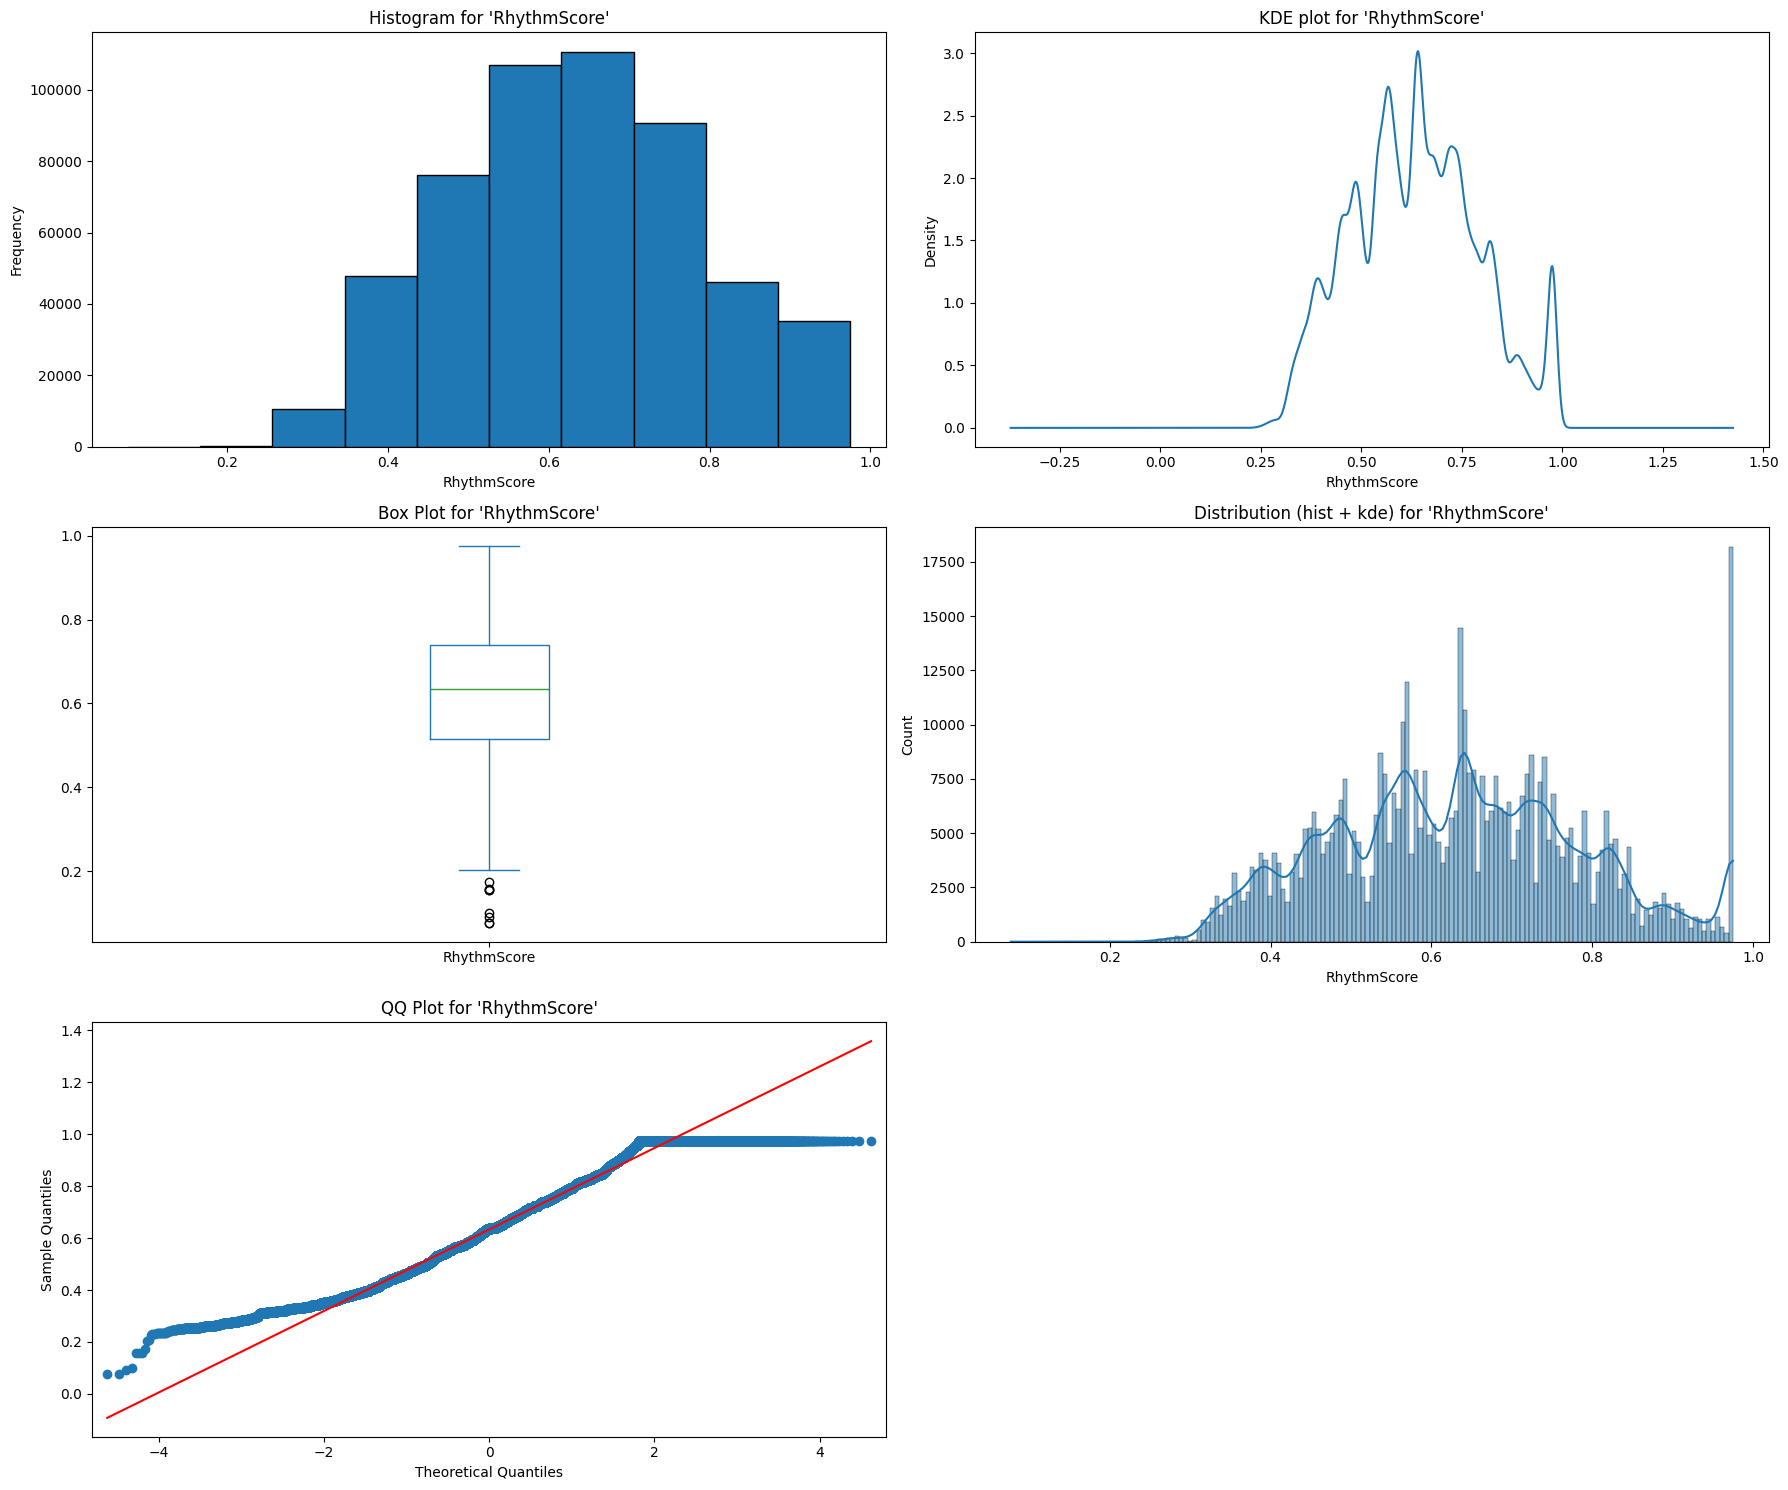

================================================== Feature: AudioLoudness ==================================================
Data type: float64
Total missing/null values: 0
Mean: -8.38
Median: -8.25
Minimum: -27.50972513
Maximum: -1.357
Std: 4.62
Skew: -0.309


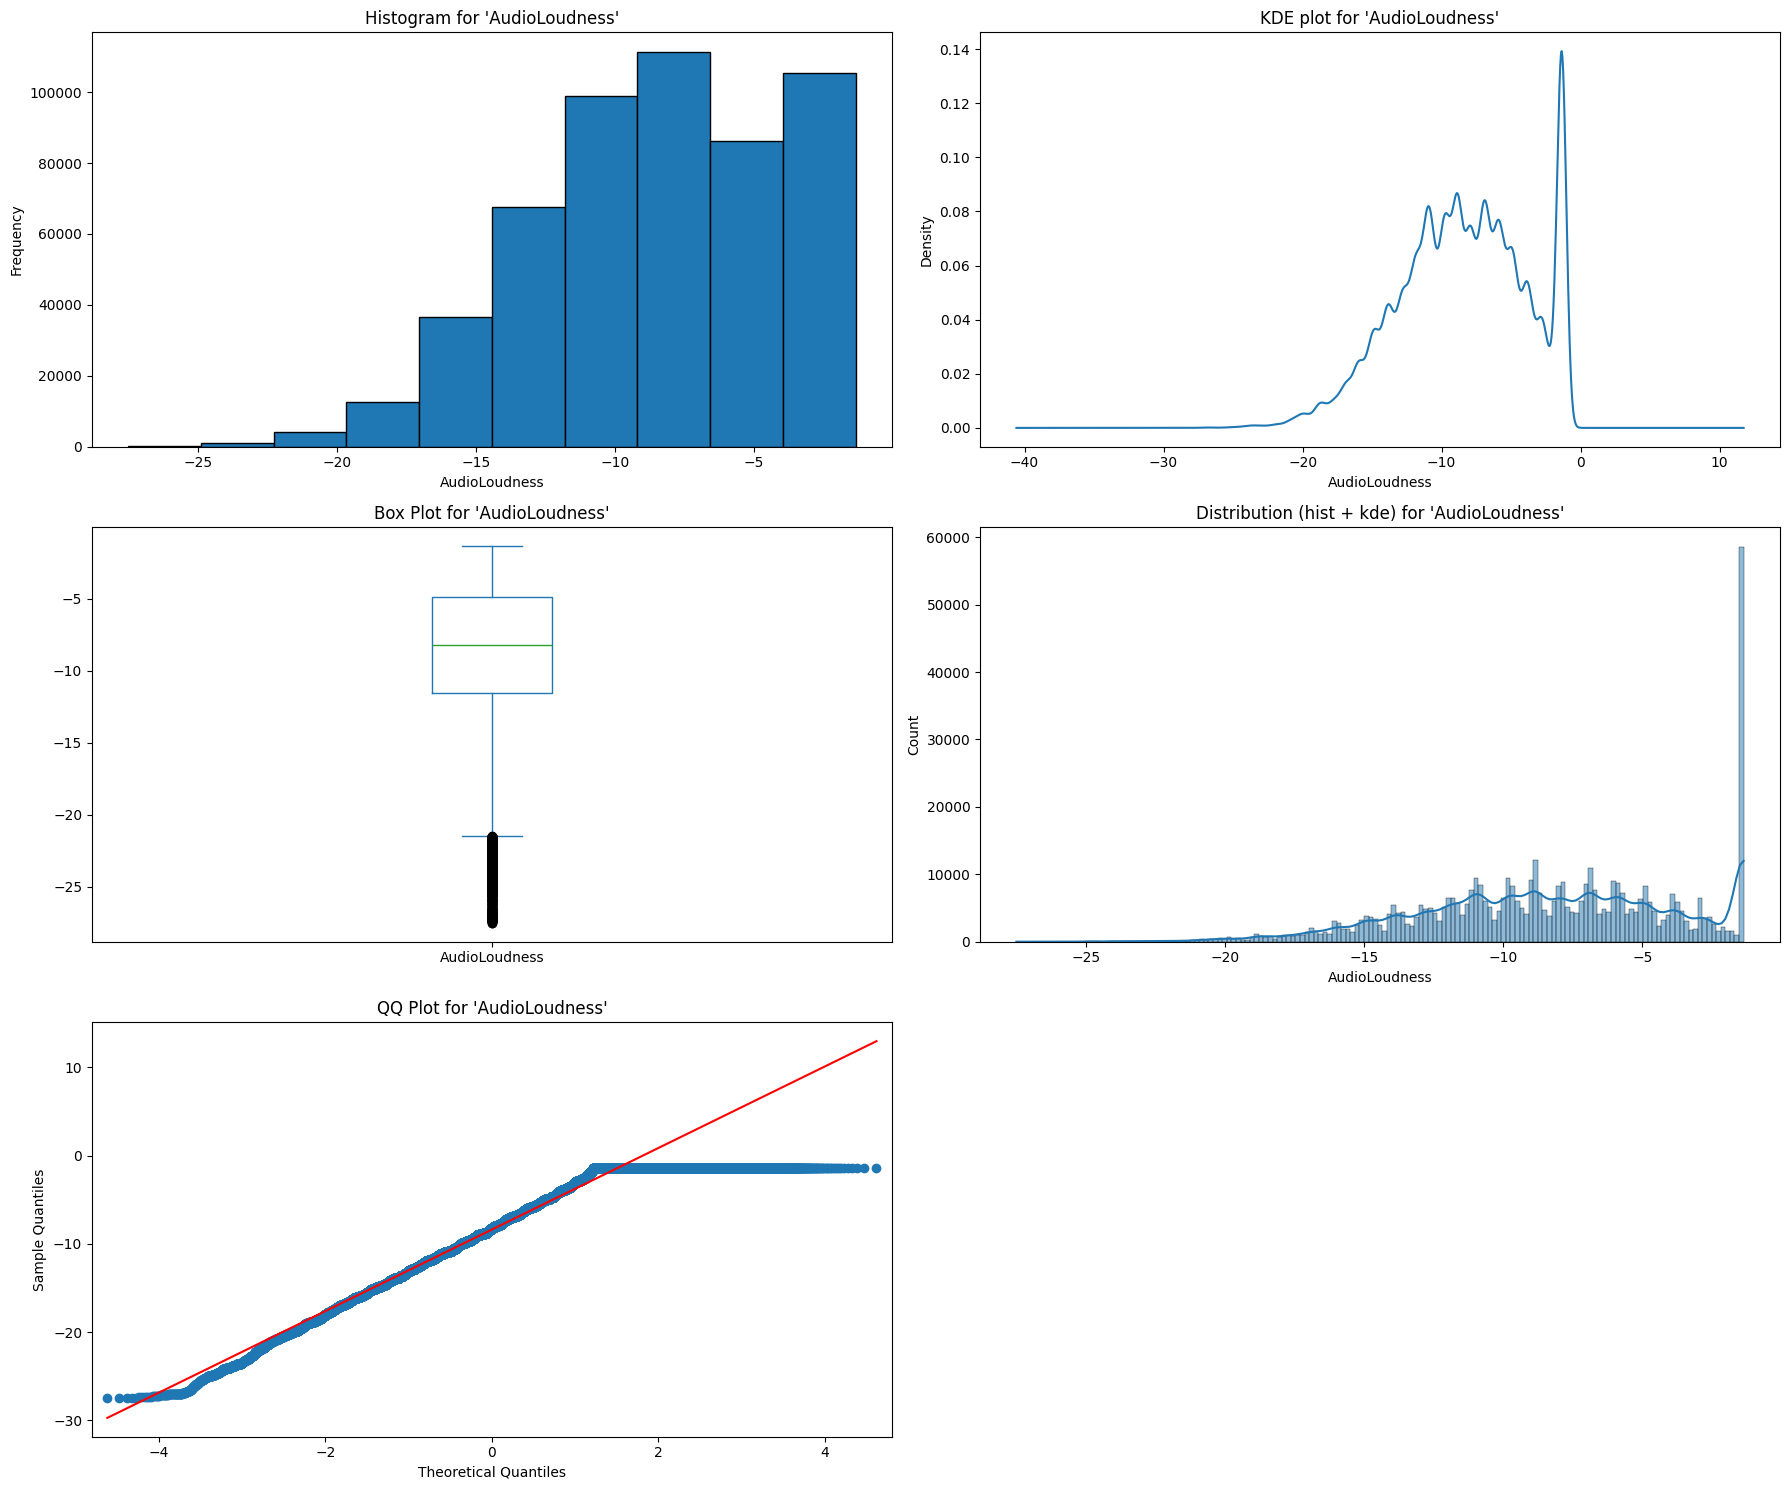

================================================== Feature: VocalContent ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.07
Median: 0.07
Minimum: 0.0235
Maximum: 0.256401015
Std: 0.05
Skew: 0.789


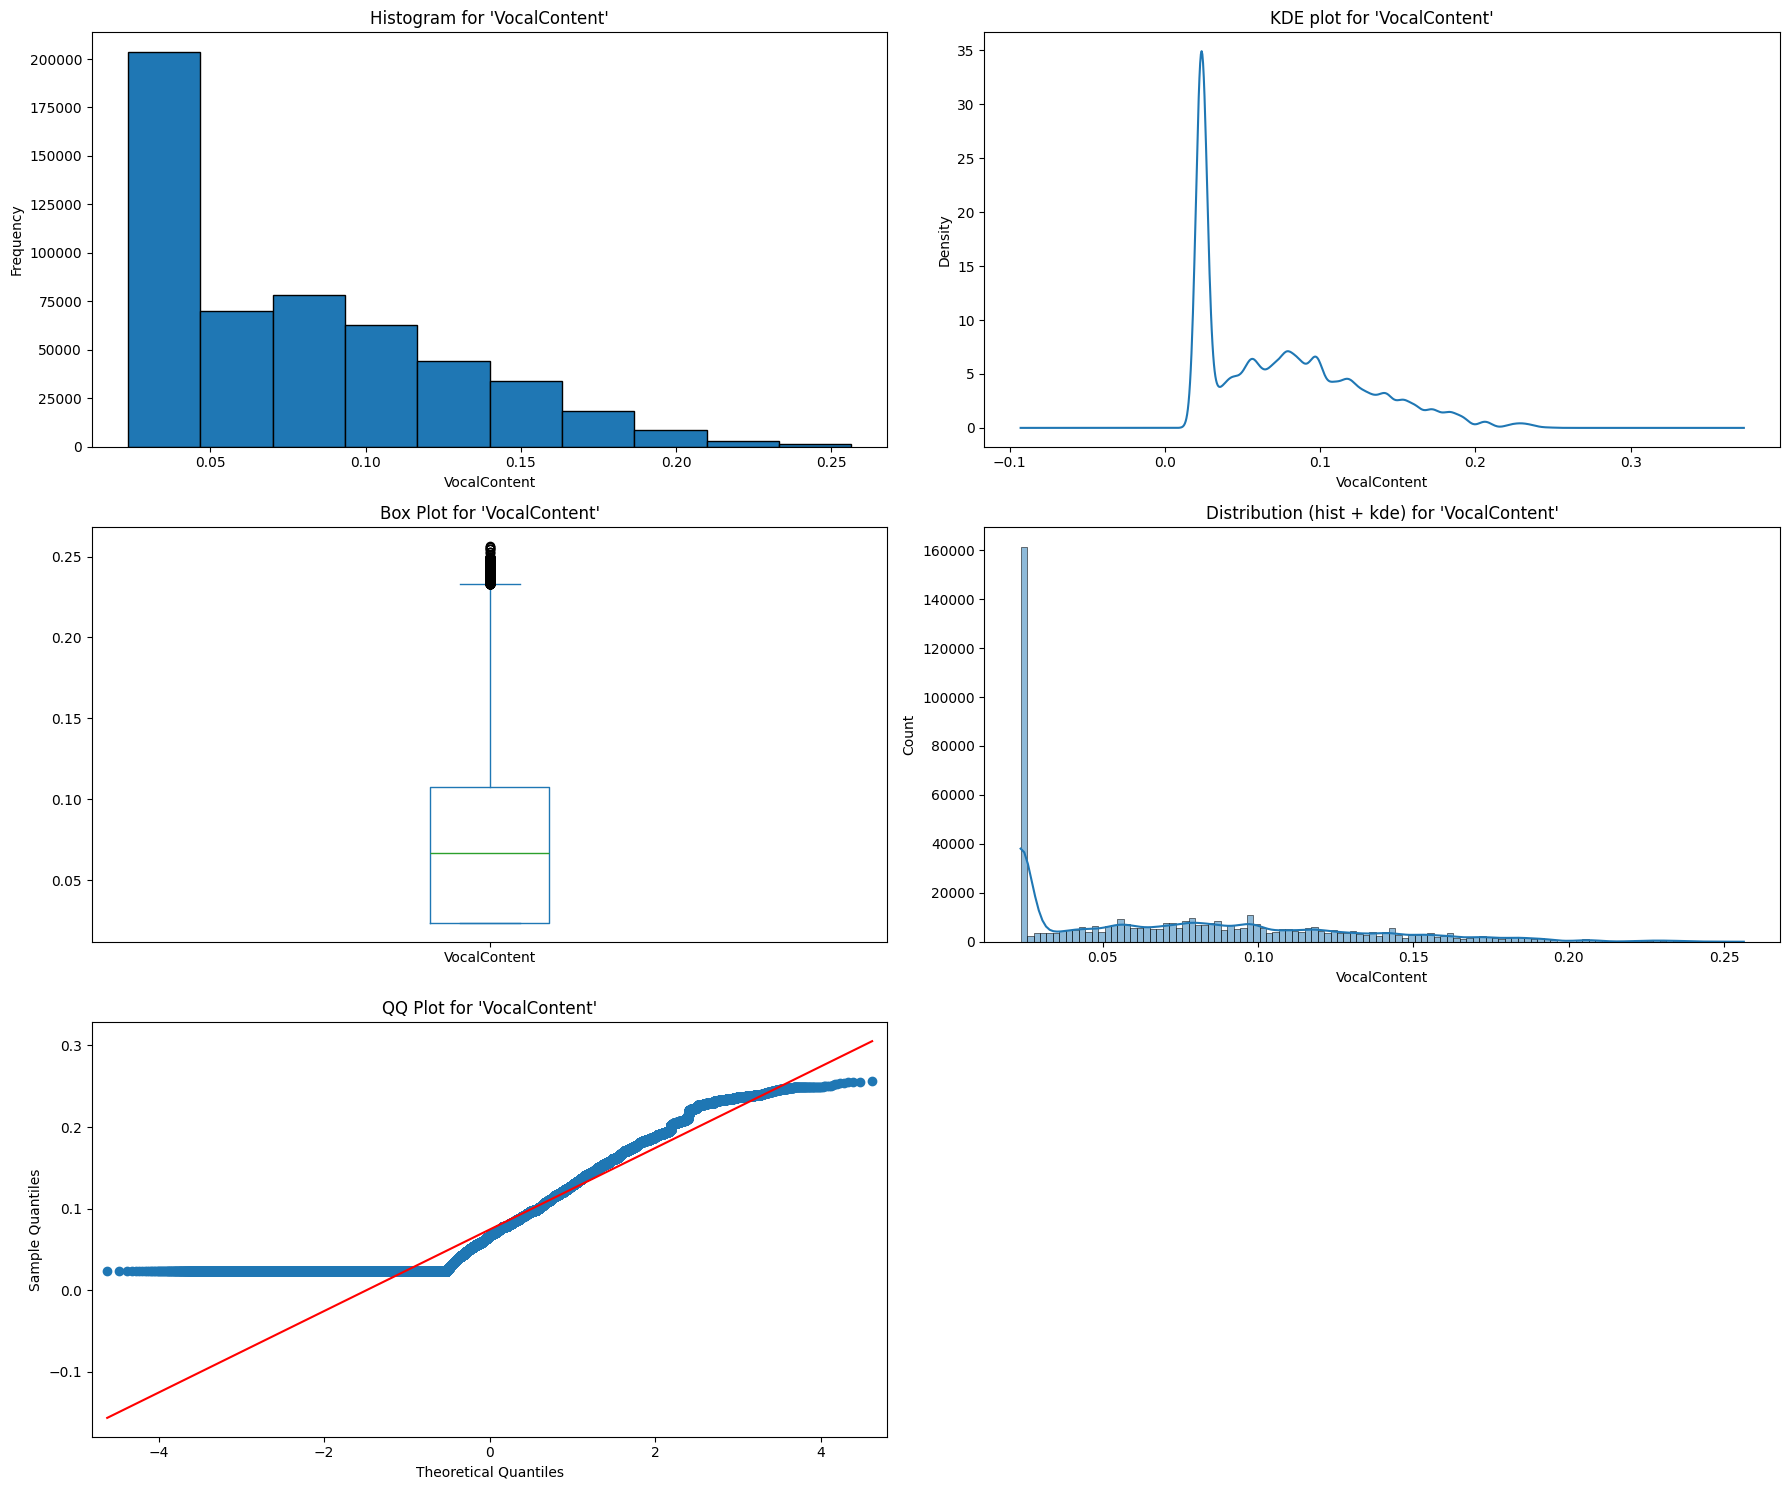

================================================== Feature: AcousticQuality ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.26
Median: 0.24
Minimum: 5.36e-06
Maximum: 0.995
Std: 0.22
Skew: 0.786


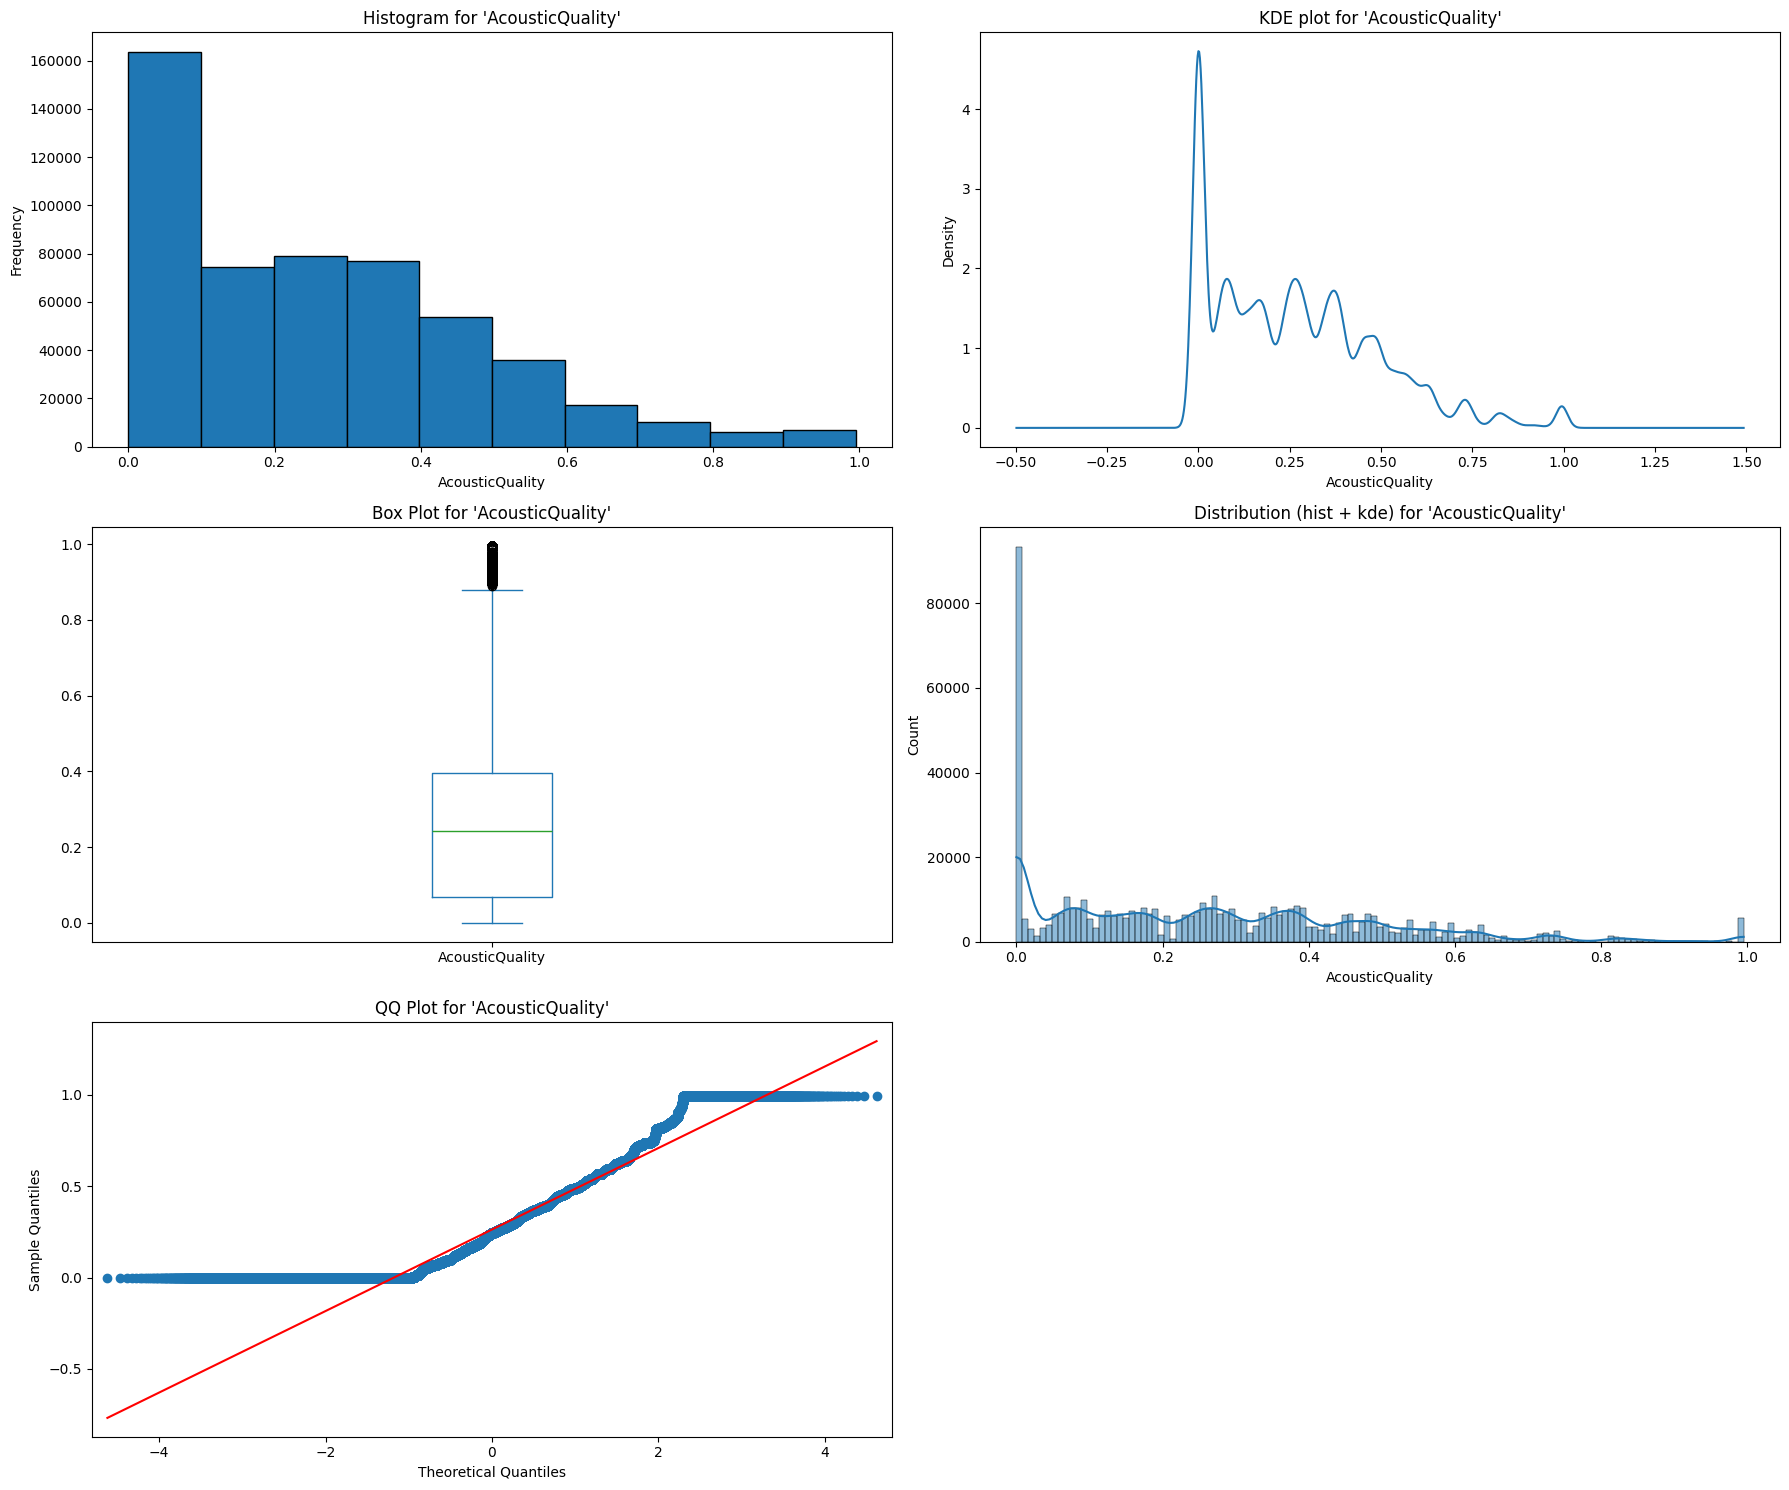

================================================== Feature: InstrumentalScore ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.12
Median: 0.07
Minimum: 1.07e-06
Maximum: 0.869257975
Std: 0.13
Skew: 1.036


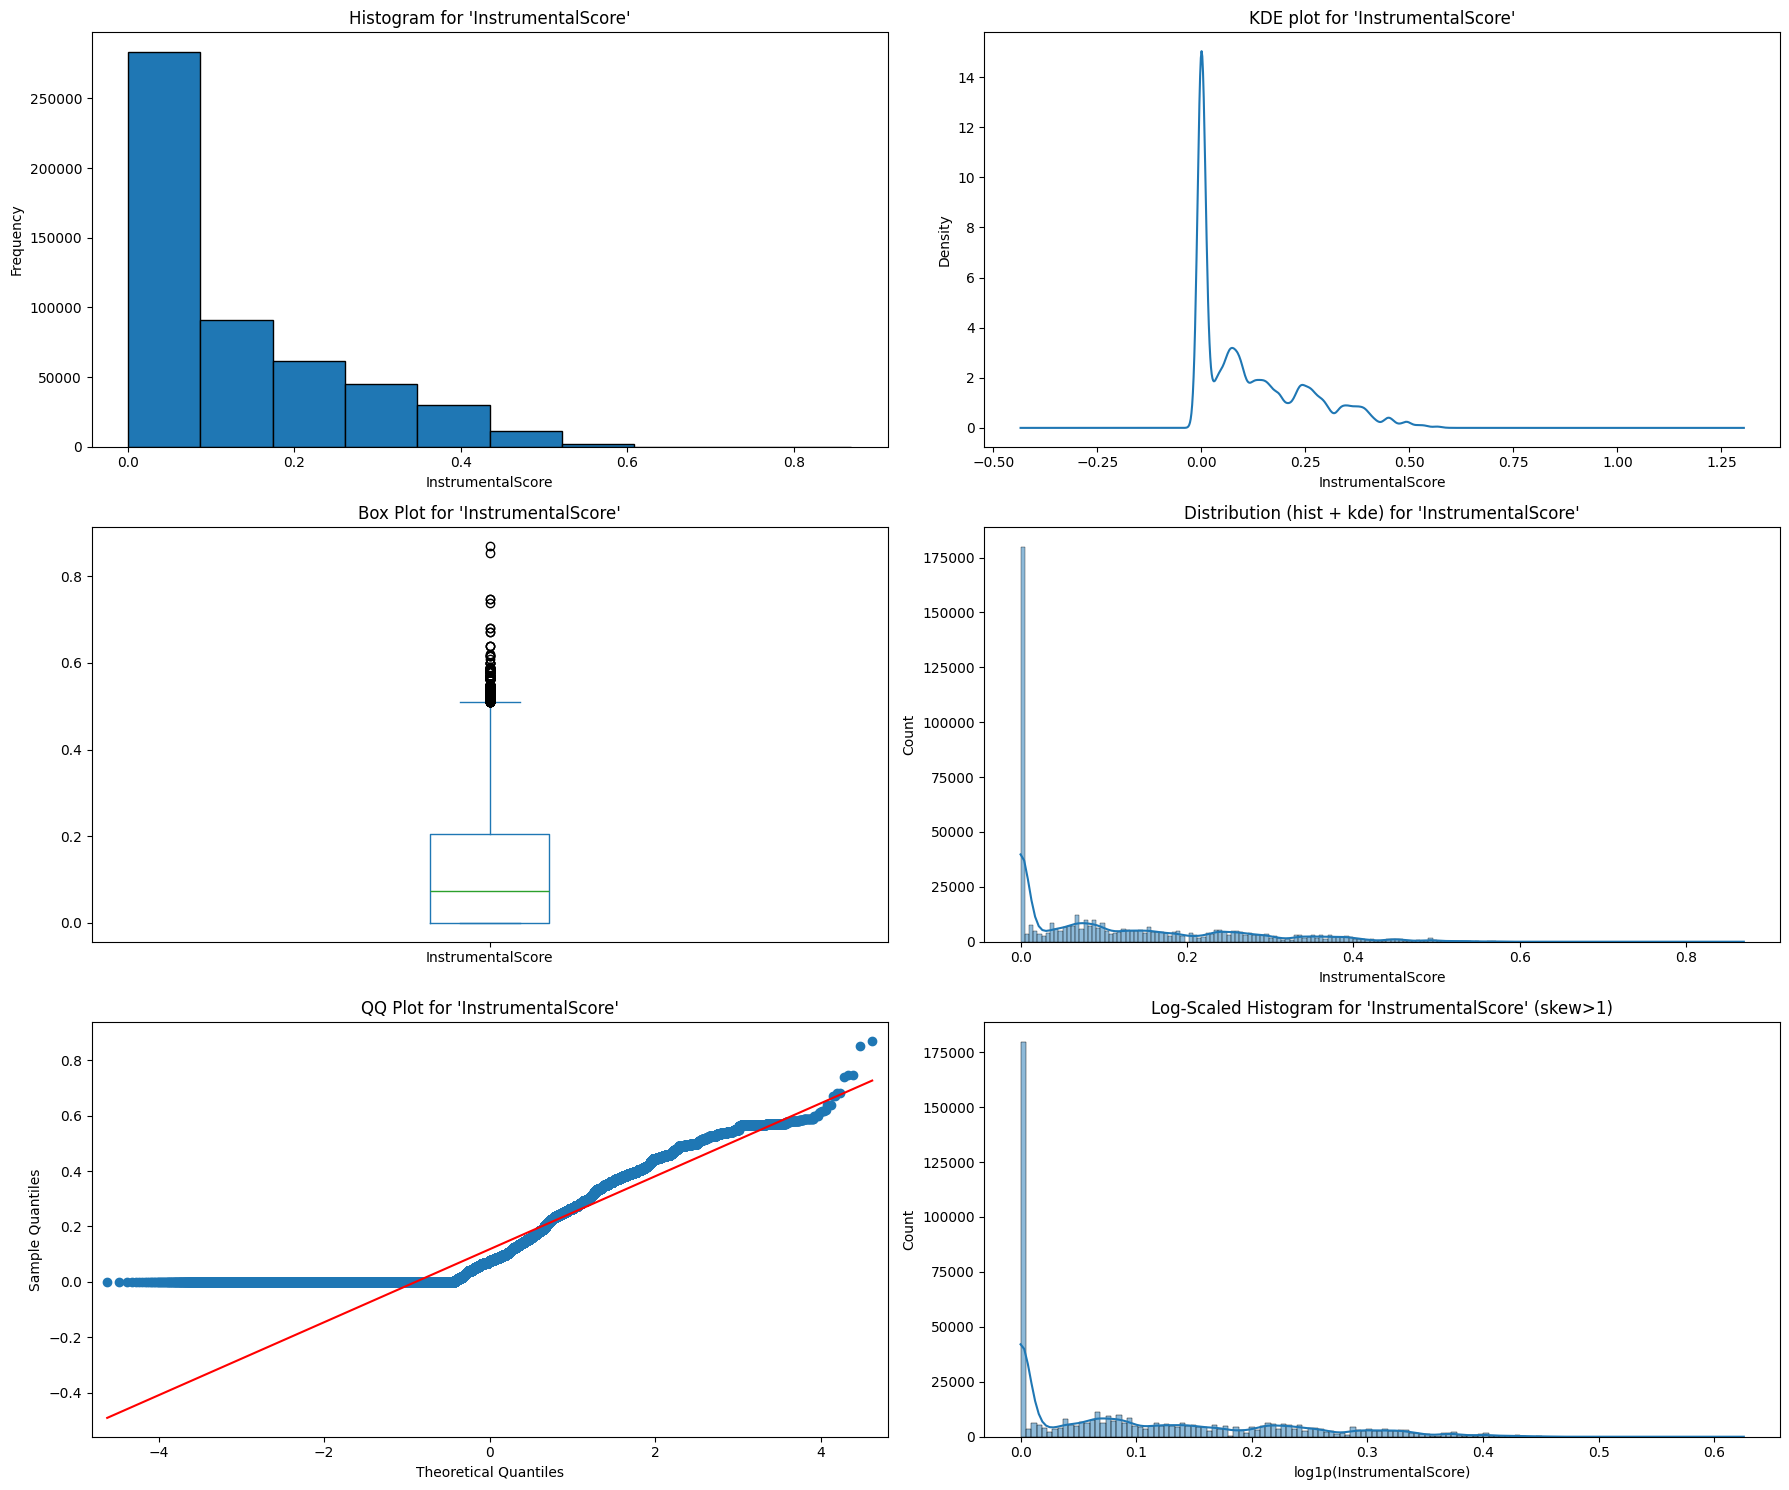

================================================== Feature: LivePerformanceLikelihood ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.18
Median: 0.17
Minimum: 0.0243
Maximum: 0.599924031
Std: 0.12
Skew: 0.393


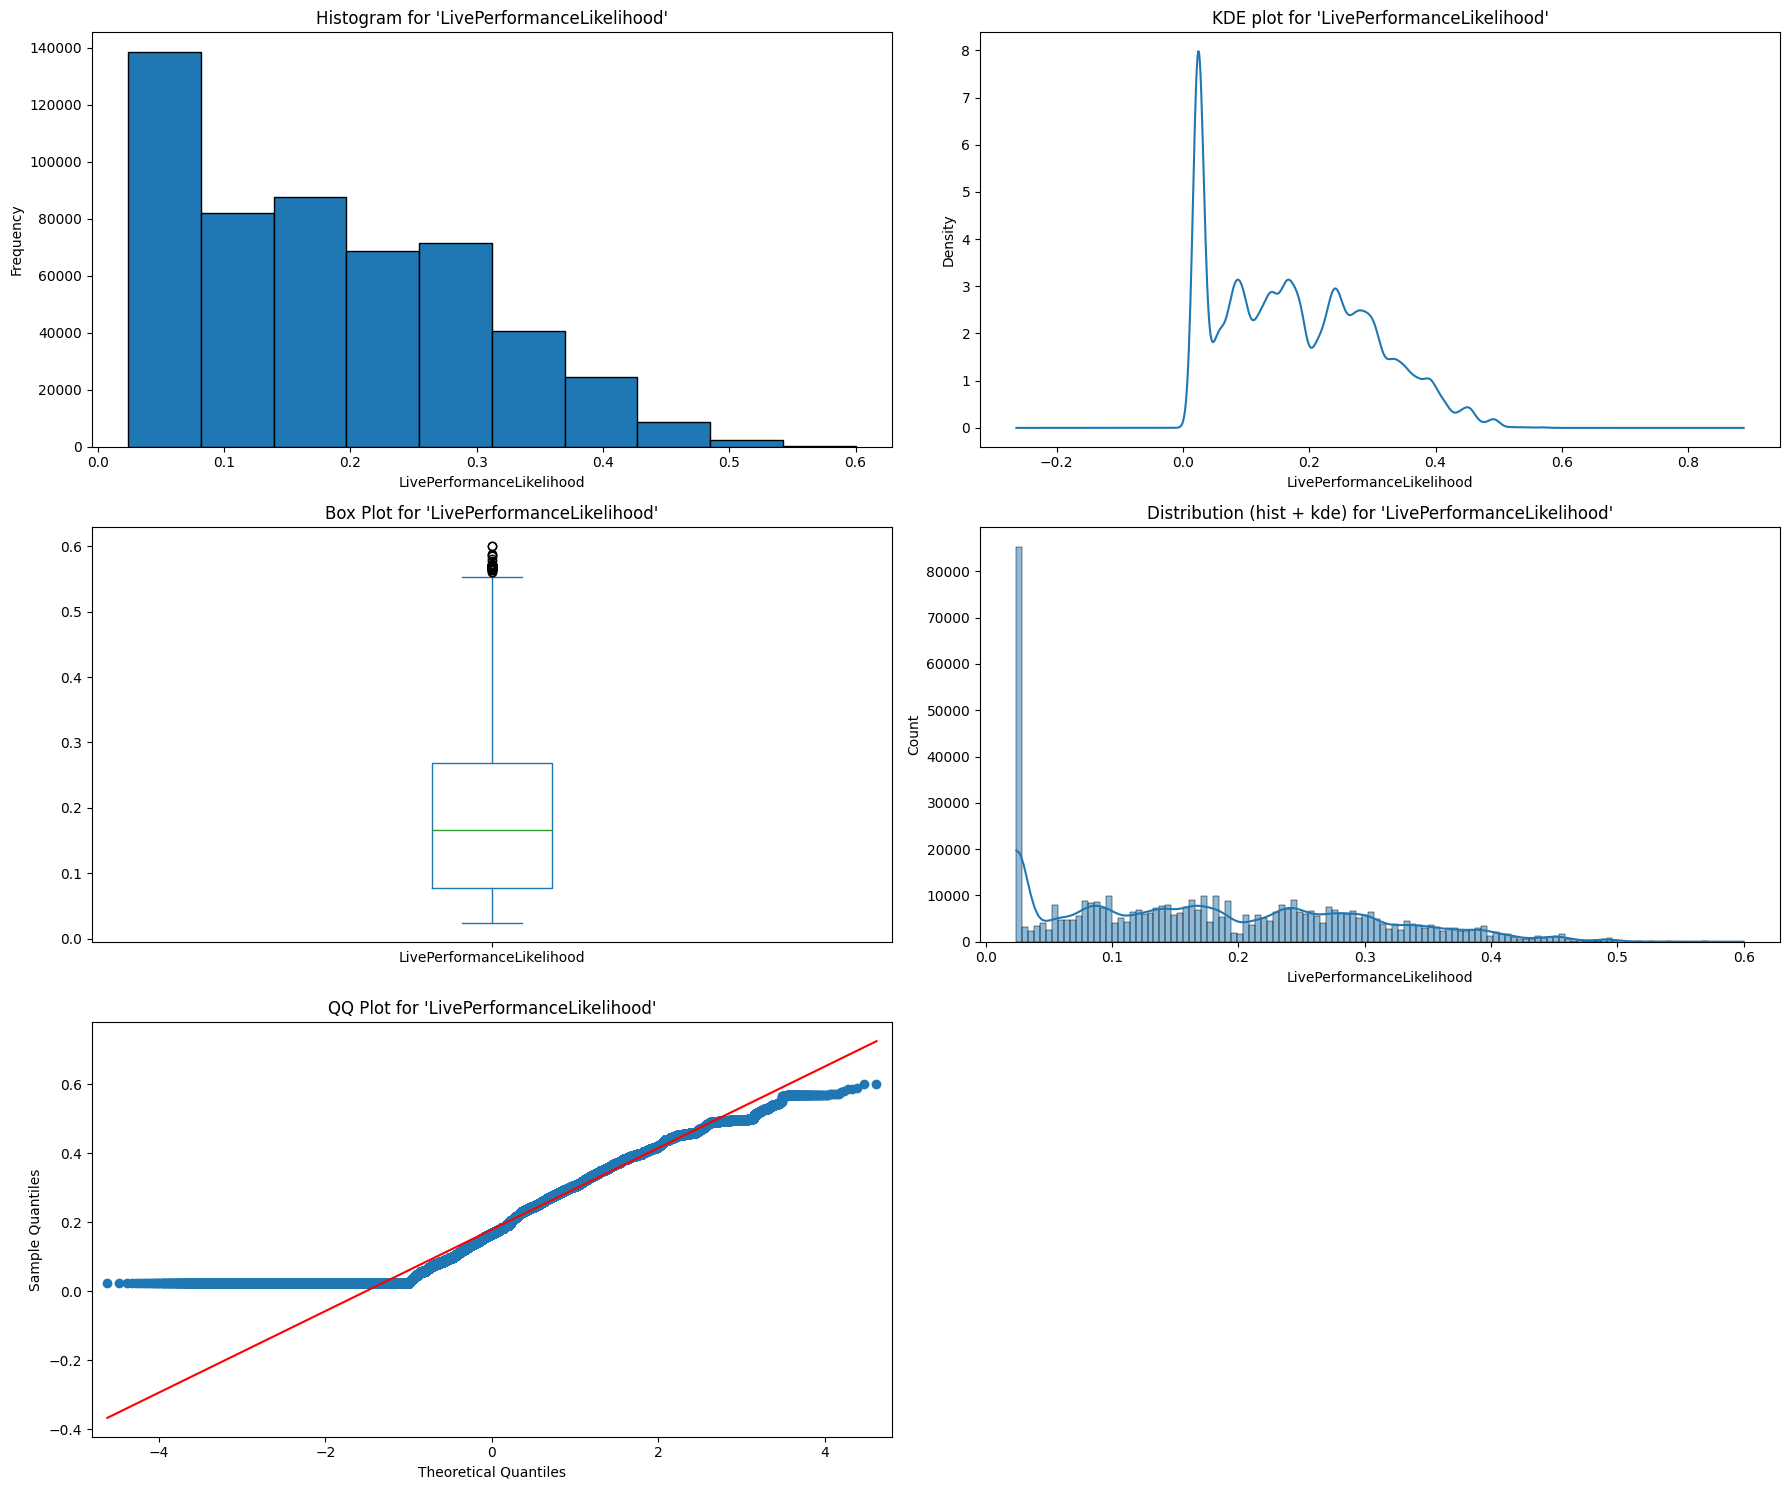

================================================== Feature: MoodScore ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.56
Median: 0.56
Minimum: 0.0256
Maximum: 0.978
Std: 0.23
Skew: -0.269


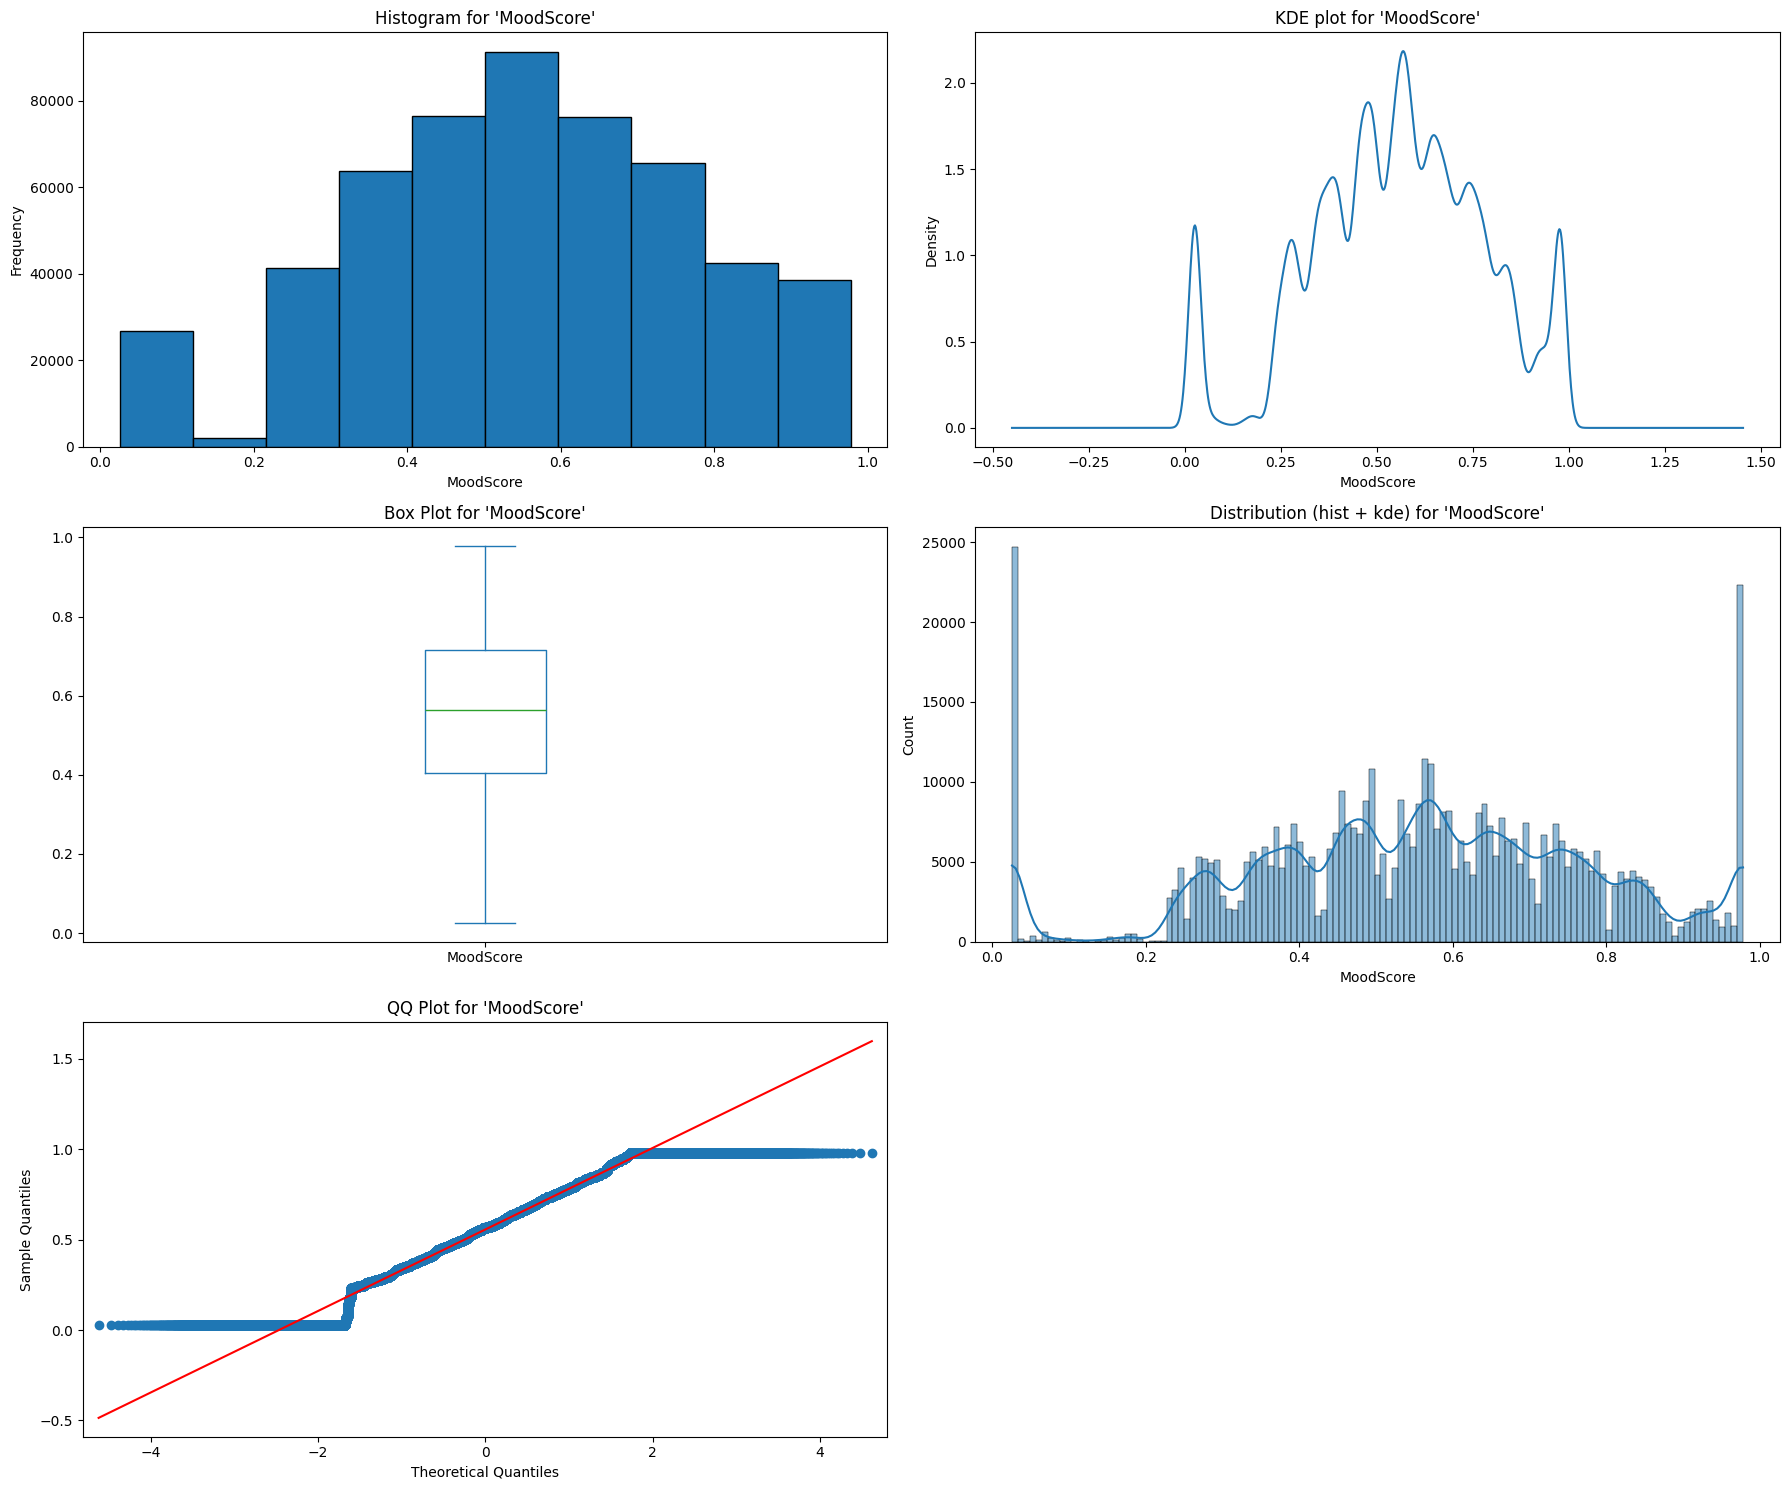

================================================== Feature: TrackDurationMs ==================================================
Data type: float64
Total missing/null values: 0
Mean: 241903.69
Median: 243684.06
Minimum: 63973.0
Maximum: 464723.2281
Std: 59326.6
Skew: -0.19


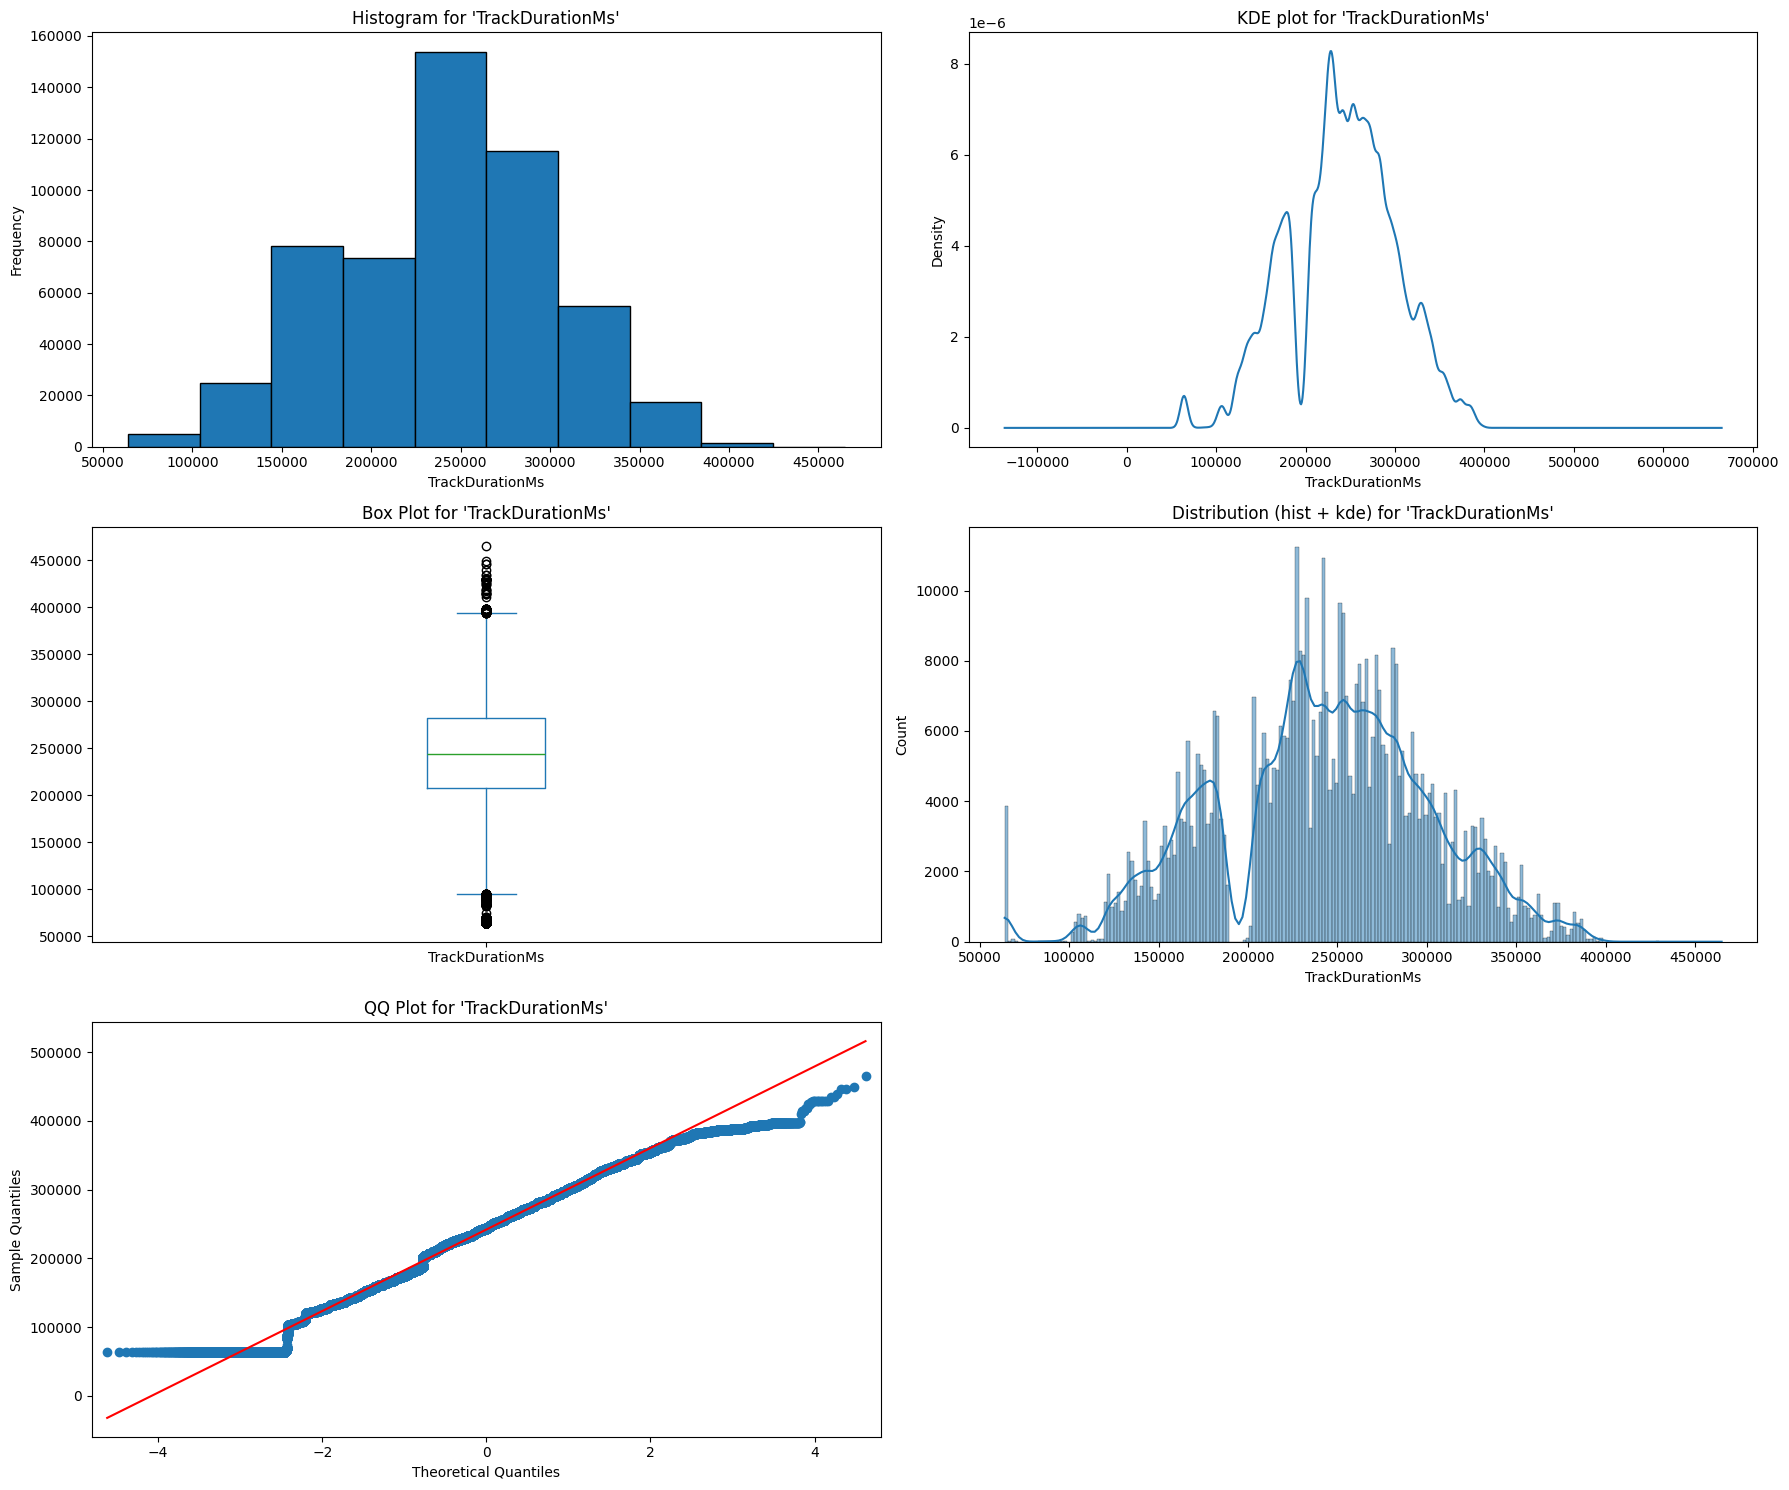

================================================== Feature: Energy ==================================================
Data type: float64
Total missing/null values: 0
Mean: 0.5
Median: 0.51
Minimum: 6.67e-05
Maximum: 1.0
Std: 0.29
Skew: -0.03


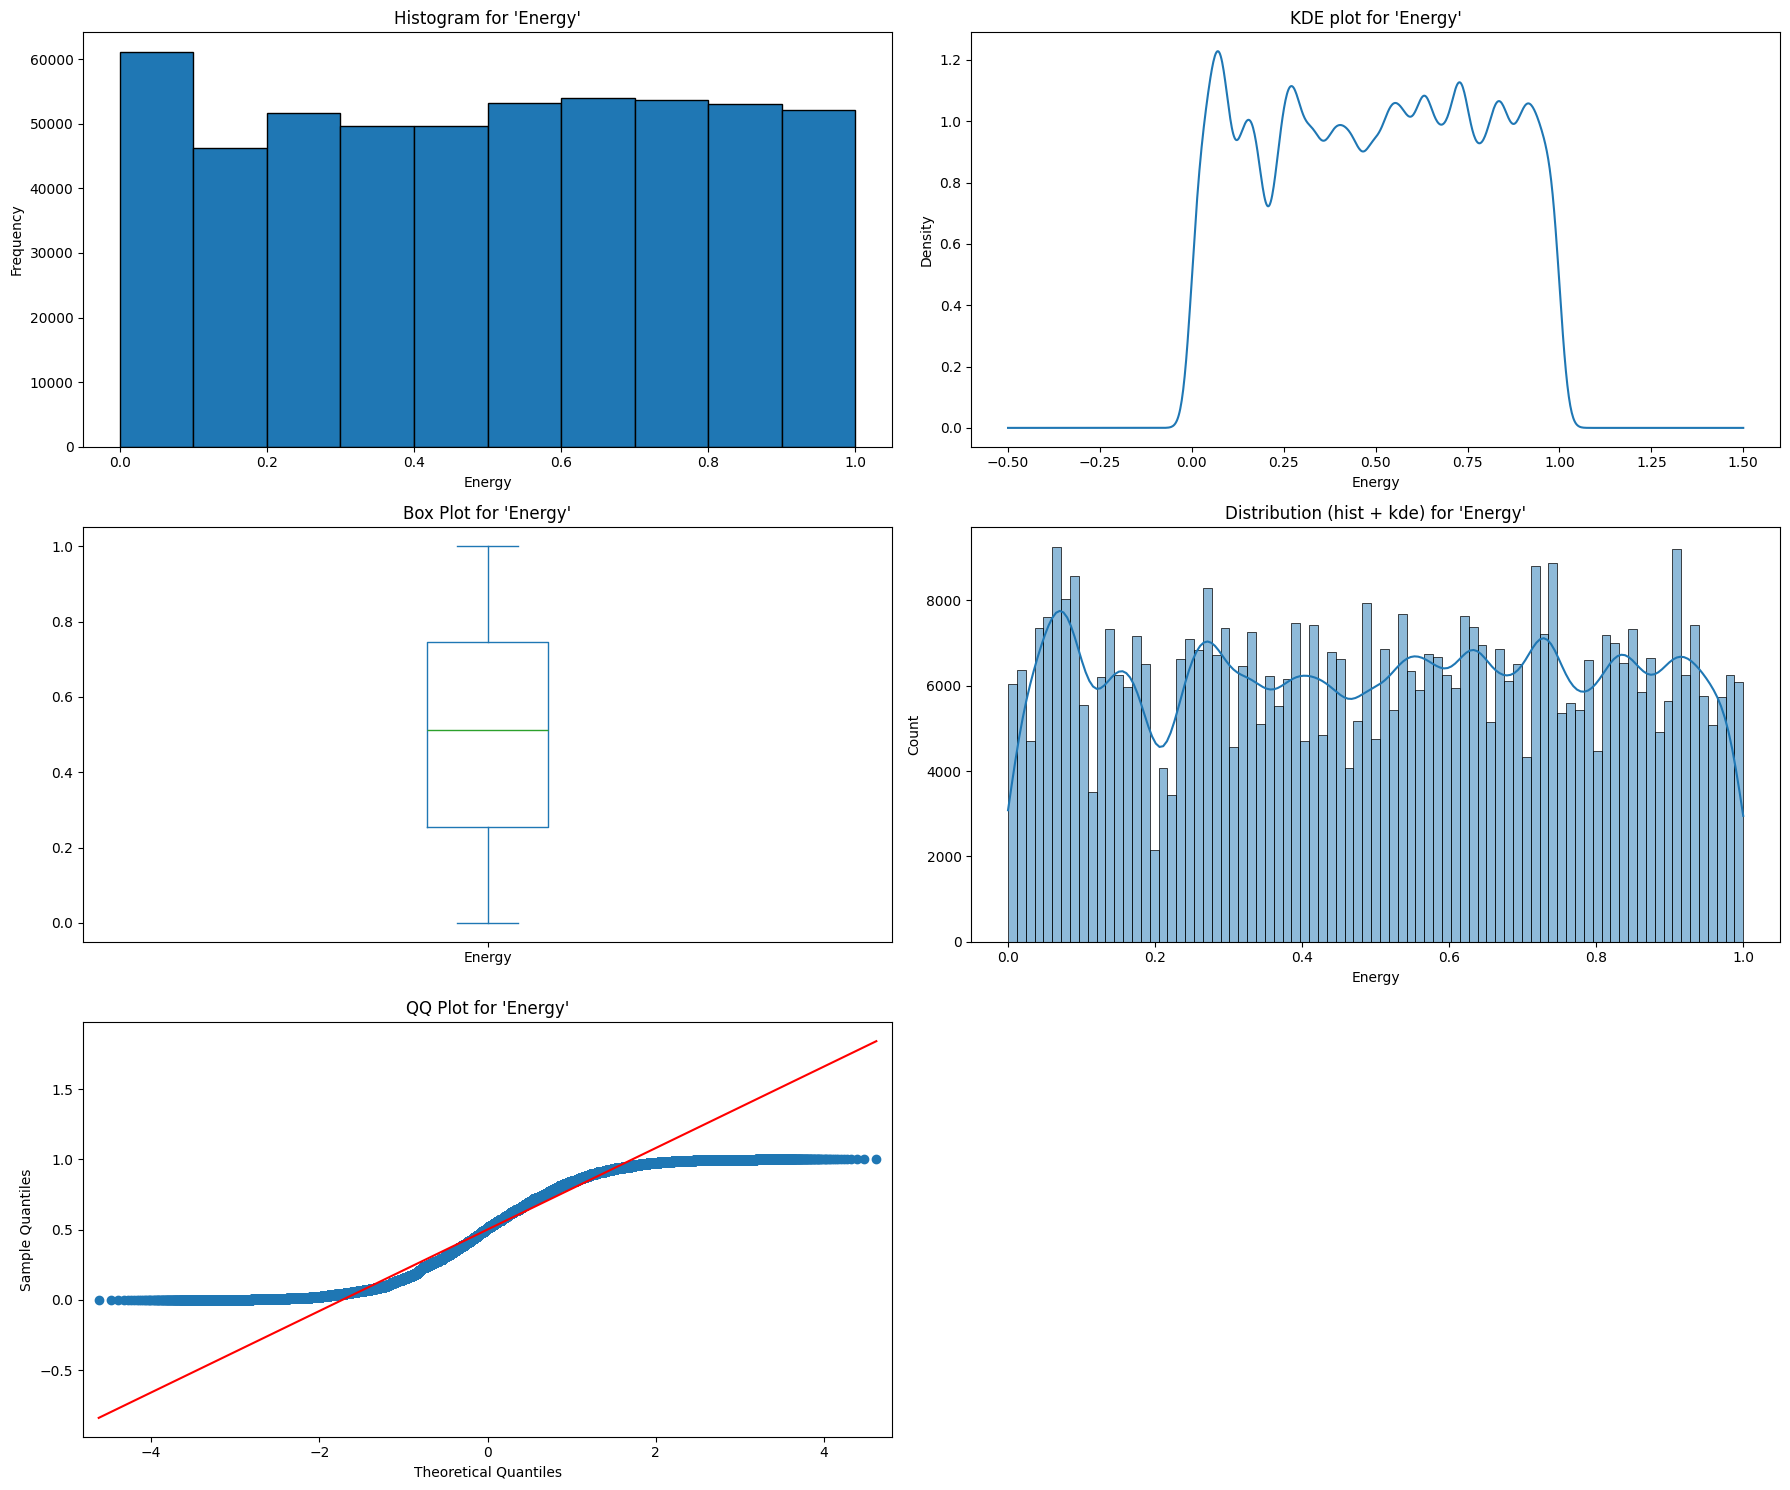

================================================== Feature: BeatsPerMinute ==================================================
Data type: float64
Total missing/null values: 0
Mean: 119.03
Median: 118.75
Minimum: 46.718
Maximum: 206.037
Std: 26.47
Skew: 0.072


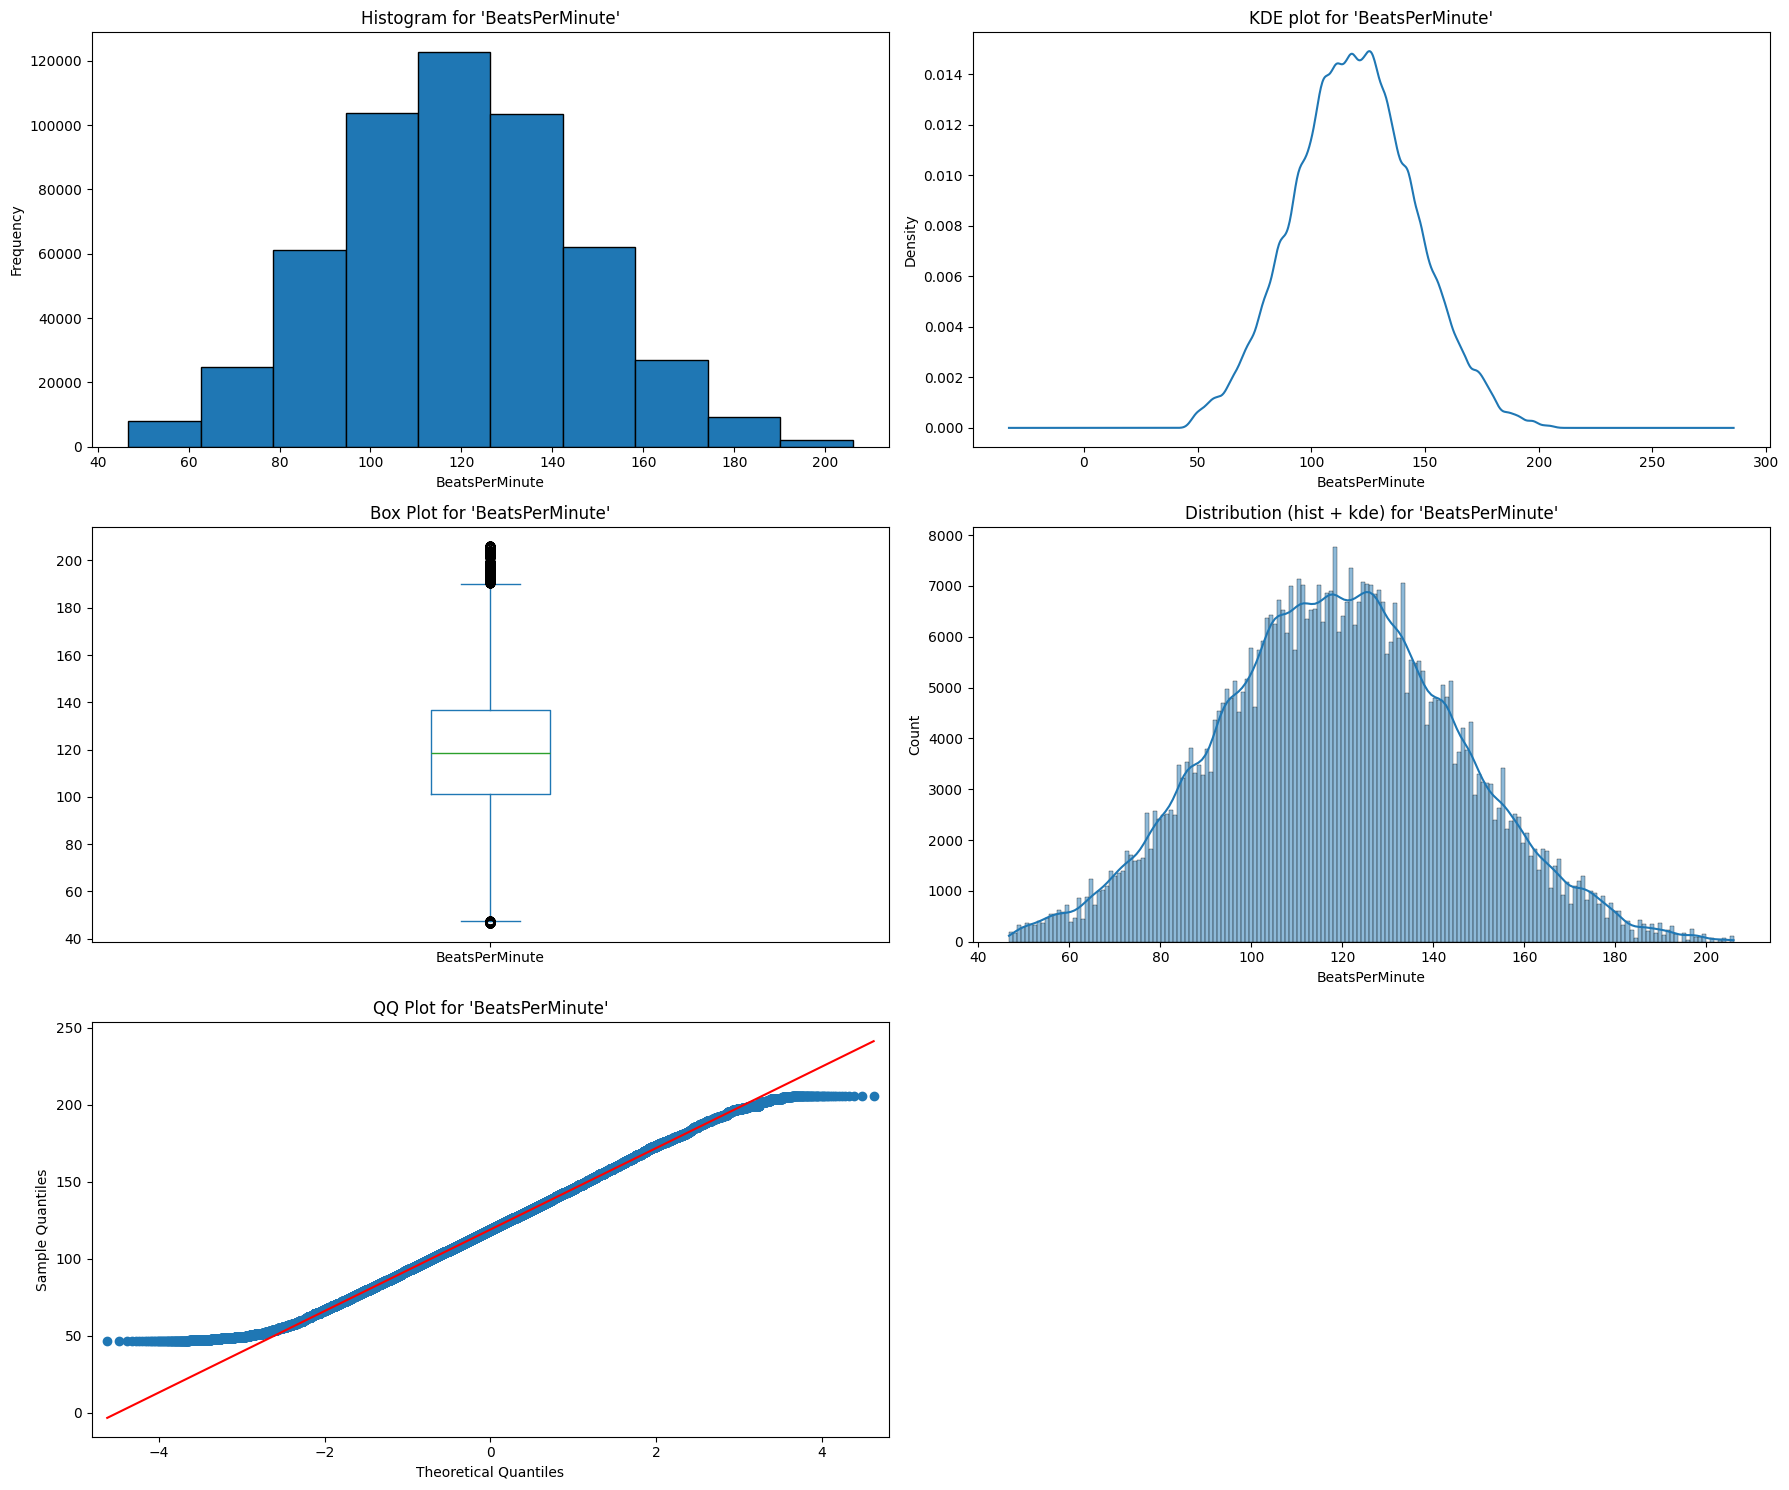

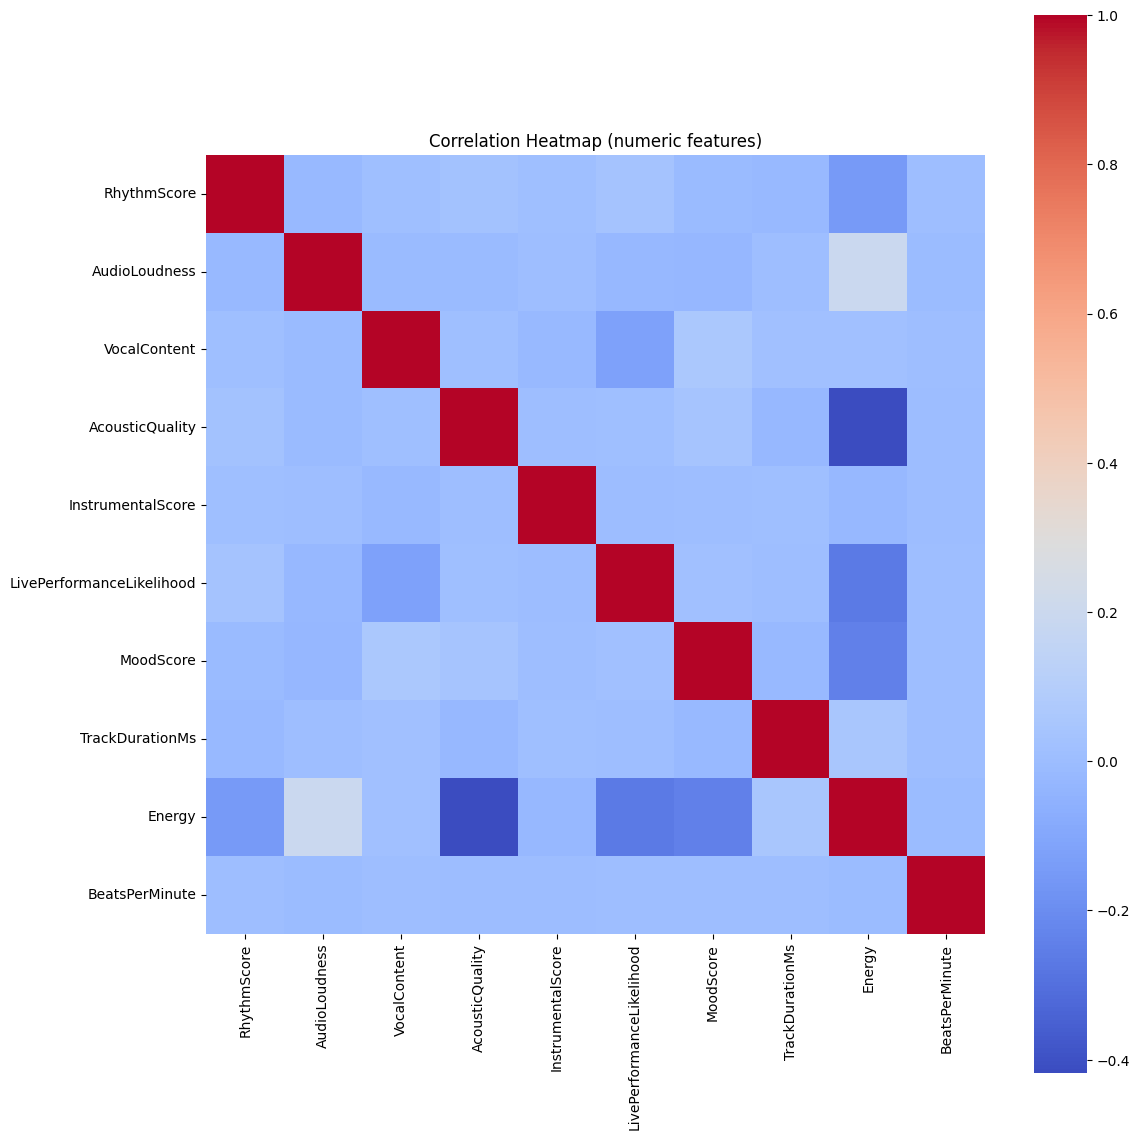

No missing values detected.


In [13]:
# Per-feature univariate + diagnostics
for feature in training_df.columns:
    # If you have a target column, pass it here (e.g., target="y" or "label")
    plot_graphs(training_df, feature, target=None)

# Dataset-level overviews (run once)
plot_overview_heatmap(training_df)
plot_missingness(training_df)

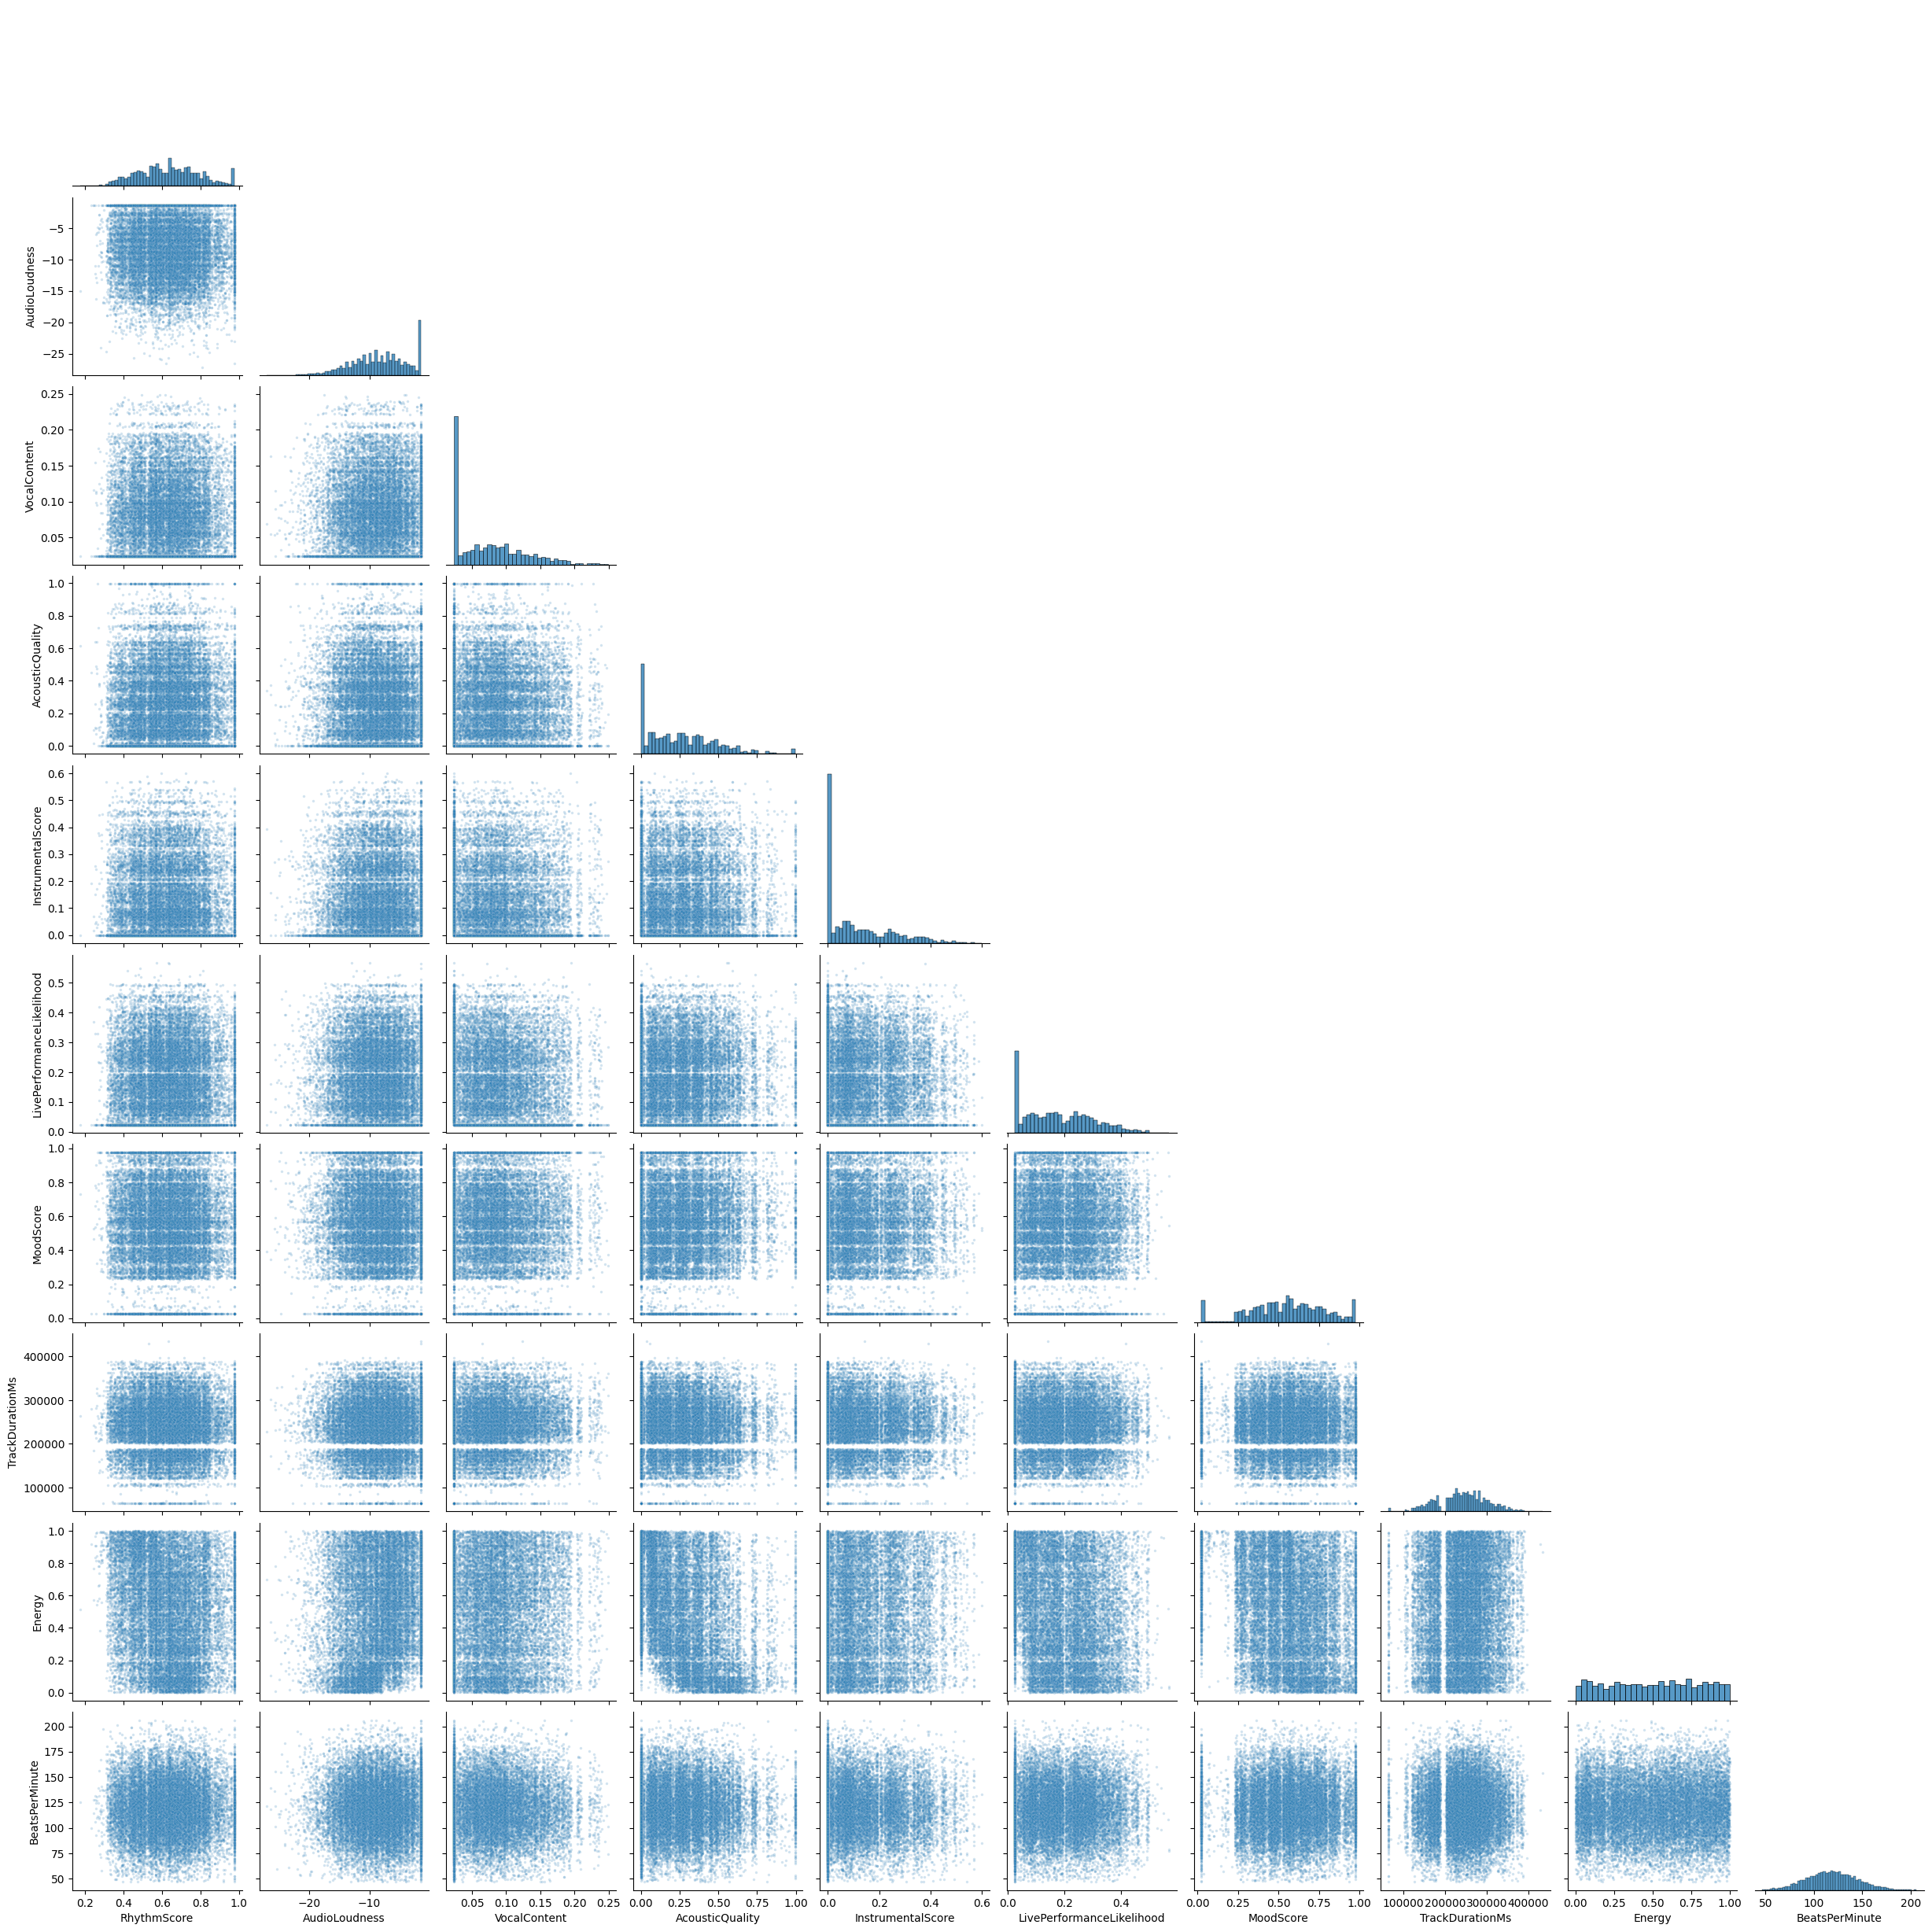

In [15]:
# Downsample, then pairplot
sample = training_df.sample(n=20000, random_state=seed)  # or 50k if fast enough
sns.pairplot(sample, corner=True, plot_kws=dict(alpha=0.2, s=6))

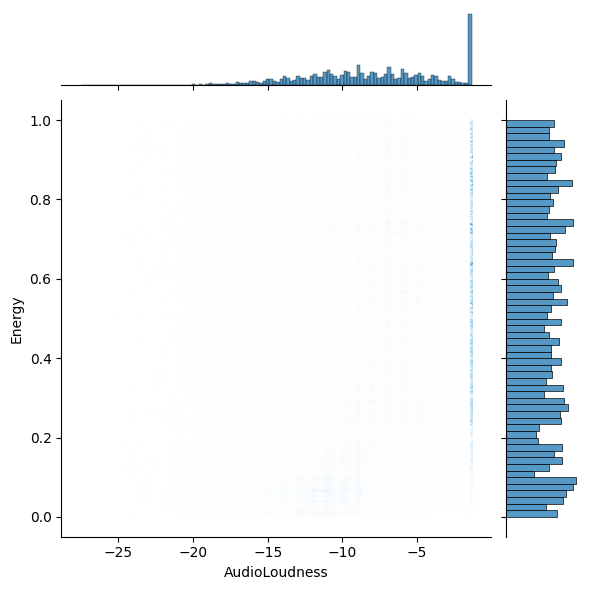

In [16]:
# Use density/hexbins for key pairs
sns.jointplot(data=training_df.sample(200000, random_state=seed),
              x="AudioLoudness", y="Energy", kind="hex", gridsize=seed)

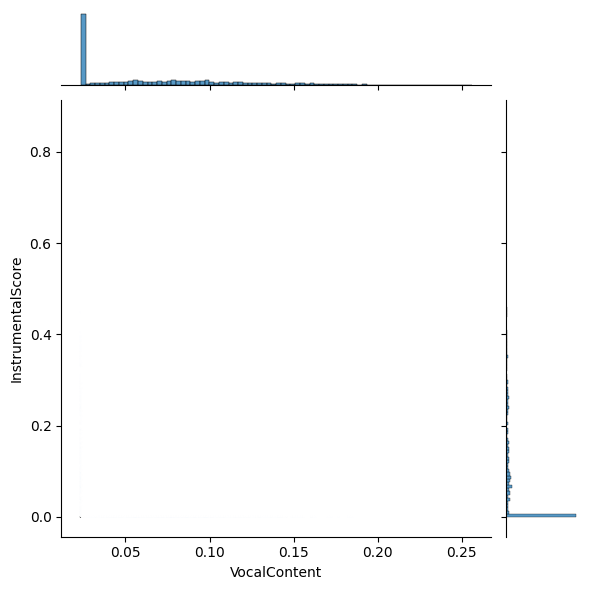

In [17]:
sns.jointplot(data=training_df.sample(200000, random_state=42),
              x="VocalContent", y="InstrumentalScore", kind="hex", gridsize=seed)

In [18]:
# Rank relationships numerically
num = training_df.select_dtypes(include="number")
pearson_top = num.corr().abs().unstack().sort_values(ascending=False)
spearman_top = num.corr(method="spearman").abs().unstack().sort_values(ascending=False)

# Show top non-trivial pairs
def top_pairs(corr, k=10):
    pairs = [(a,b,v) for (a,b),v in corr.items() if a<b]
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

top_pairs(pearson_top), top_pairs(spearman_top)


([('AcousticQuality', 'Energy', 0.4181836461567918),
  ('Energy', 'LivePerformanceLikelihood', 0.2662560533796248),
  ('Energy', 'MoodScore', 0.2417129961092973),
  ('AudioLoudness', 'Energy', 0.1924110037929794),
  ('Energy', 'RhythmScore', 0.14734982579296899),
  ('LivePerformanceLikelihood', 'VocalContent', 0.12029366153059826),
  ('MoodScore', 'VocalContent', 0.058675264327181675),
  ('Energy', 'TrackDurationMs', 0.04859663736681926),
  ('AcousticQuality', 'MoodScore', 0.03704715686042437),
  ('LivePerformanceLikelihood', 'RhythmScore', 0.0315350455881705)],
 [('AcousticQuality', 'Energy', 0.4400853391571858),
  ('Energy', 'LivePerformanceLikelihood', 0.2807073455596197),
  ('Energy', 'MoodScore', 0.2303466893152495),
  ('AudioLoudness', 'Energy', 0.2032582406213245),
  ('Energy', 'RhythmScore', 0.1654264646436655),
  ('LivePerformanceLikelihood', 'VocalContent', 0.15592137575931672),
  ('MoodScore', 'VocalContent', 0.07130530643581397),
  ('Energy', 'TrackDurationMs', 0.0490938825